# Datojen haku ja esikäsittely

In [1]:
from set_path import set_path
mainpath, path = set_path('areadata')

In [2]:
from read_and_prepare_data import read_and_prepare_data
stat, post, kunta_stat, vaalidata = read_and_prepare_data(path)

read_and_prepare_data  read from file
read_post_muncipalities  read from file


In [3]:
from selected_cols import selected_cols
numeric_features, categorical_features = selected_cols(largeset=False, parties=True)

In [4]:
import pandas as pd
import shap
import xgboost as xgb
from sklearn.feature_selection import  mutual_info_classif

from gaussian_model import create_and_draw_best_gaussian_mix
from gaussian_model import create_gaussian_model


from draw_and_create_clusters import display_circles

from create_prediction import create_prediction
from prepare_and_scale_data import prepare_and_scale_data
from create_prediction import select_kbest
from select_columns_and_clean_data import select_columns_and_clean_data
from draw_all import draw_features

from shap_Xboost import shap_Xboost
from shap_proba_individual import print_reason, print_individual_waterfall
from shap_vals import shap_vals

from print_examples import plot_difference, create_example_df, find_most_different, show_real_share
from create_target_columns import create_target_columns
from create_new_values import create_new_values
from create_share_of_values import create_share_of_values

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.display.max_colwidth = 100

list_of_parties = ['VIHR', 'KOK', 'SDP', 'KD', 'KESK', 'RKP', 'PS', 'VAS']
included_col_start = 'Ääniosuus'
all_included_columns = create_target_columns(list_of_parties, included_col_start)
included_col_start = 'Äänet yhteensä lkm'
all_included_columns_2 = create_target_columns(list_of_parties, included_col_start)
share_of_votes = 'Ääniosuus'
total_votes = 'Äänet yhteensä lkm Äänioikeutetut yhteensä'


n_components = 2
n_clusters = 6
axis_ranks=  [(0,1)]
alpha = 0.8
scaled = True
silhouette_print = 0
covariance_type = 'full'

filename_model_aic = 'aic_cluster'
filename_model_bic = 'bic_cluster'

data, X, test, gmm_bic, gmm_aic = create_and_draw_best_gaussian_mix(filename_model_aic, filename_model_bic, path, stat, stat, numeric_features=numeric_features, categorical_features=categorical_features, scaled=scaled, covariance_type = covariance_type)
data = create_gaussian_model(data, X, gmm_bic)

print(data['cluster'].value_counts())

load model
Silhouette Coefficient: 0.101 Calinski Harabaz Index: 242
2    1059
3    1033
0     491
4     236
1     151
Name: cluster, dtype: int64


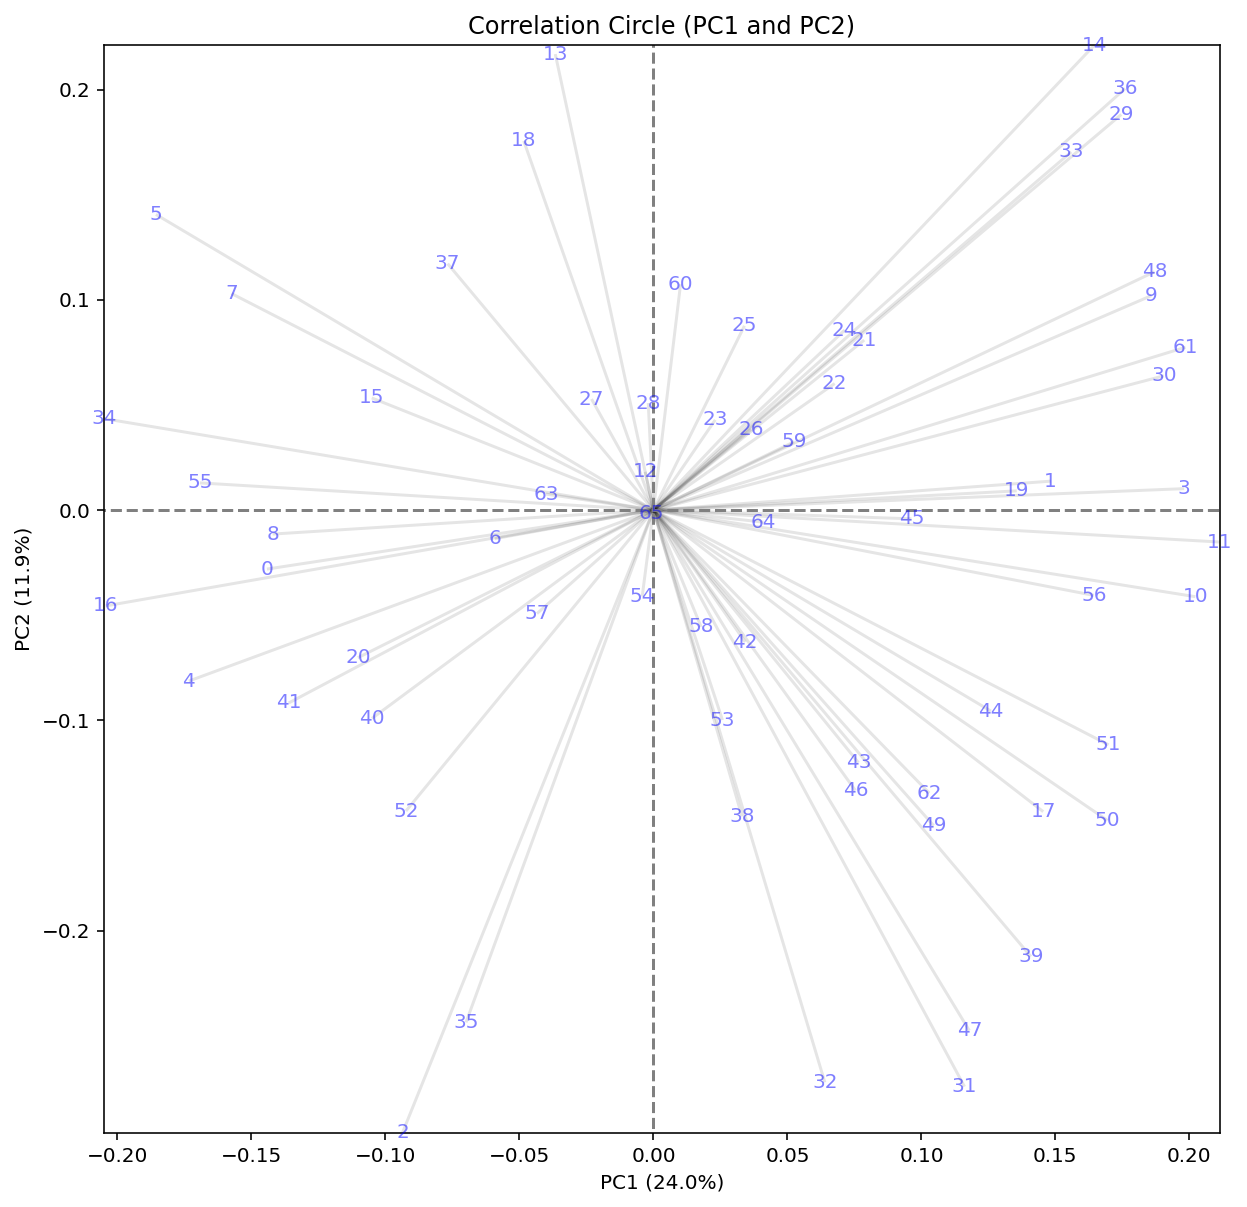

In [5]:
axis_ranks =  [(0,1)]
n_components = 2
labels = [X.columns.get_loc(c) for c in X.columns]

pcs = display_circles(X, n_components=n_components, axis_ranks=axis_ranks, labels=labels, label_rotation=0, lims=None)

In [6]:
for c in X.columns:
    print(X.columns.get_loc(c), c)

0 Miehet, 2018 (HE) osuudesta asukkaat
1 Naiset, 2018 (HE) osuudesta asukkaat
2 Asuntojen keskipinta-ala, 2018 (RA) osuus total
3 Talotyypit yhteensä 2019 Neliöhinta (EUR/m2) osuus total
4 Asumisväljyys, 2018 (TE) osuus total
5 Asukkaiden keski-ikä, 2018 (HE) osuus total
6 Postinumeroalueen pinta-ala osuus area_code
7 Perusasteen suorittaneet, 2018 (KO) osuudesta asukkaat
8 Ammatillisen tutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
9 Ylioppilastutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
10 Alemman korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
11 Ylemmän korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
12 Asukkaiden ostovoimakertymä, 2017 (HR) osuudesta asukkaat osuus total
13 Asunnot, 2018 (RA) osuudesta asukkaat
14 Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat
15 Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat
16 Pientaloasunnot, 2018 (RA) osuudesta asukkaat
17 Työlliset, 2017 (PT) osuudesta asukkaat
18 Työttömät, 2017 (PT) osuudesta

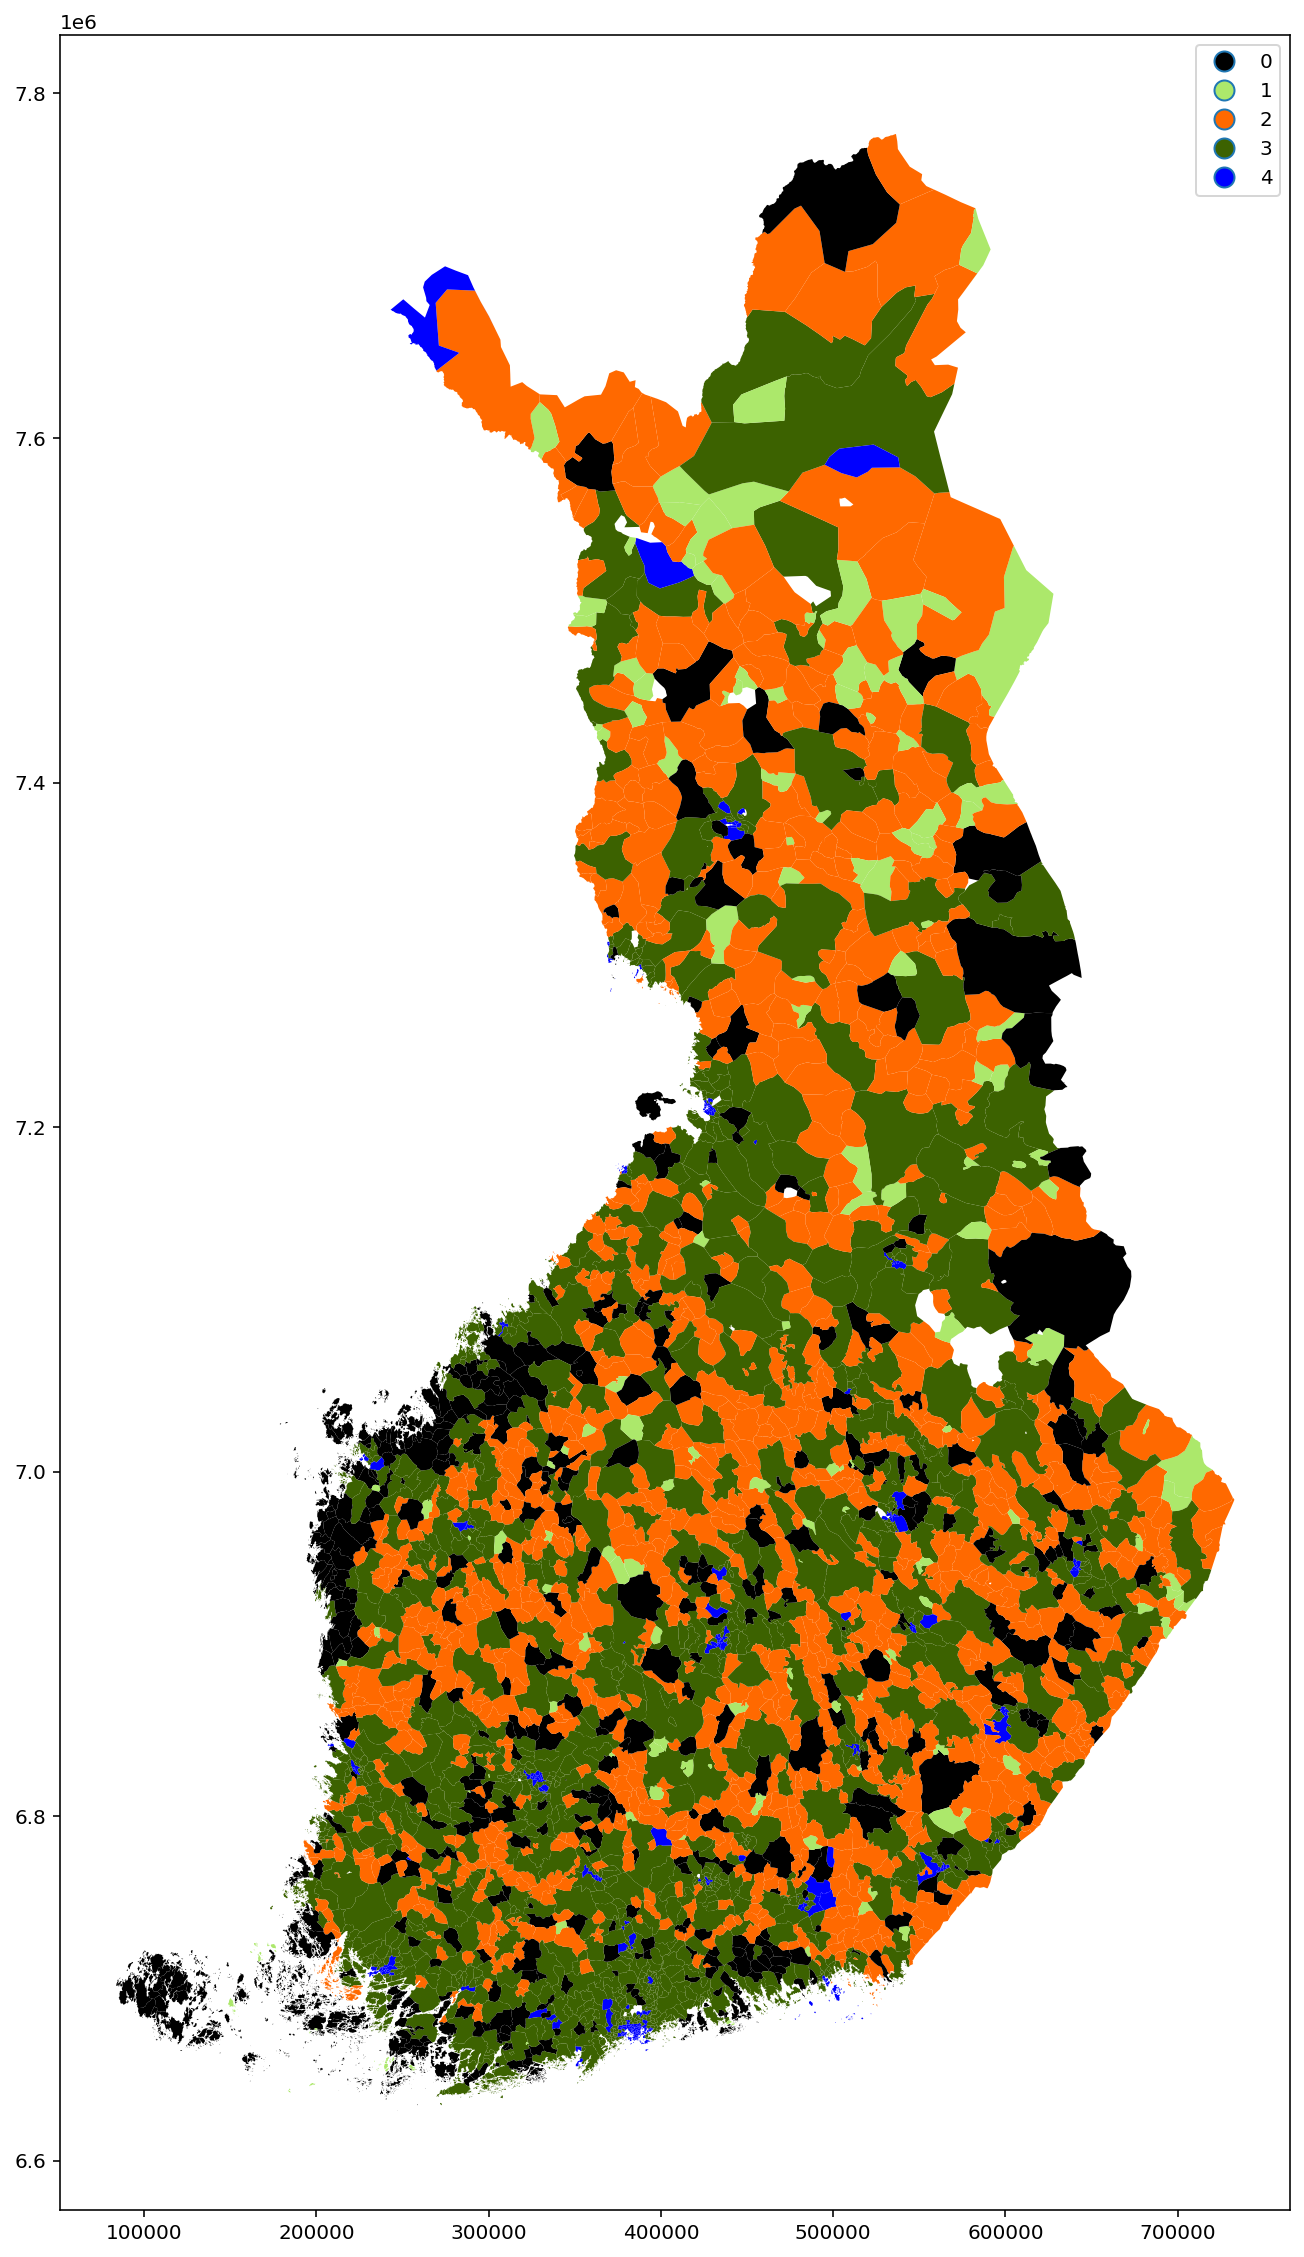

In [7]:
import geopandas
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('my cmap', ['black', 'lightgreen', 'gold',  'red',  'green', 'blue'])
draw = geopandas.GeoDataFrame(pd.DataFrame(data[['cluster', 'geometry']], dtype=object),geometry='geometry')
draw.plot(column='cluster', cmap=cmap, legend=True, figsize=(20,20))

In [8]:
import xgboost as xgb
from sklearn.feature_selection import  mutual_info_classif
from create_prediction import create_prediction

target = 'cluster'

ennustettu = "uusi" + target

#Check
#k_selected need to have correct values, if they are too large, evrything needs to be started again
k_selected = 'all'

test_size = 0.2

#Scalers attributes
kbest_score_func = mutual_info_classif
#set values to model configuration attributes

num_class = len(data['cluster'].unique()) #how many classes we are working with

metric = 'merror'
Skfold=True
Verbose = False
testing=True
scaled = False

params = {
    # Parameters that we are going to tune.
    'objective':'multi:softmax',
    'num_class' : num_class,
    'booster' : 'gbtree',
    'eval_metric' : metric
}

filename_model = 'gauss_xgboost_cluster'

data, test, features_df, importance_df, model, params, y_pred, X_train, y_train, X_test, y_test = create_prediction(filename_model, path, data, data, target, kbest_score_func, metric, params, numeric_features, categorical_features, scaled=scaled, testing=testing)
data_no_use, X_scale, X = prepare_and_scale_data(data, pd.DataFrame(), numeric_features, categorical_features)


Create model
[0]	train-merror:0.06061	test-merror:0.12121
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 50 rounds.
Stopping. Best iteration:
[67]	train-merror:0.00000	test-merror:0.05387

testing
Start with xgb.cv params: merror: 0.07365300000000001
Best xgb.cv params: max_depth 2, min_child_weight 1, merror: 0.06481466666666667
Best xgb.cv params: gamma 0.2, merror: 0.06439399999999999
Best xgb.cv params: lambda 0.0, alpha 0.0, merror: 0.061027
Best xgb.cv params: colsample_bytree 0.8, subsample 1.0, merror: 0.05976466666666666
Best xgb.cv params: eta 0.6, merror: 0.06144766666666667
Found hyperparameters with 1 rounds 
{'objective': 'multi:softmax', 'num_class': 5, 'booster': 'gbtree', 'eval_metric': 'merror', 'max_depth': 2, 'min_child_weight': 1, 'gamma': 0.2, 'lambda': 0.0, 'alpha': 0.0, 'colsample_bytree': 0.8, 'subsample': 1.0, 'eta': 0.6}

[0]	train-merror:0.15909	test-merror:0.16667
Multi

In [9]:
filename_model = 'gauss_mymodel_xgboost_cluster'
filename_shap =  'gauss_shap.npz'
mymodel, shap_values, shap_interaction_values, shap_expected_value = shap_Xboost(filename_model, filename_shap, path, data, target, params, X)


Create model
Create shap files


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [10]:
data[data['cluster']==1][features_df['Column'].head(5).to_list()].describe()

Omistusasunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
count                                                       151.000000   
mean                                                          0.006181   
std                                                           0.075954   
min                                                           0.000000   
25%                                                           0.000000   
50%                                                           0.000000   
75%                                                           0.000000   
max                                                           0.933333   

       Vuokra-asunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
count                                                            151.0   
mean                                                               0.0   
std                                                                0.0   
min                                                                0.0   
25%                                                                0.0   
50%                                                                0.0   
75%                                                                0.0   
max                                                                0.0   

       11. Yrittäjätulot yhteensä Yhteensä Saajien lukumäärä osuudesta verotetut  \
count                                                                 151.000000   
mean                                                                    0.100045   
std                                                                     0.150265   
min                                                                     0.000000   
25%                                                                     0.000000   
50%                                                                     0.000000   
75%                                                                     0.214986   
max                                                                     0.595745   

       Nuorten yksinasuvien taloudet, 2018 (TE) osuudesta taloudet  \
count                                                   151.000000   
mean                                                      0.000221   
std                                                       0.002713   
min                                                       0.000000   
25%                                                       0.000000   
50%                                                       0.000000   
75%                                                       0.000000   
max                                                       0.033333   

       4.2.9 Kuntoutusraha ja -avustus Yhteensä Saajien lukumäärä osuudesta verotetut  
count                                                                           151.0  
mean                                                                              0.0  
std                                                                               0.0  
min                                                                               0.0  
25%                                                                               0.0  
50%                                                                               0.0  
75%                                                                               0.0  
max                                                                               0.0

In [11]:
importance_df[importance_df['Importance type']==importance_df['Importance type'].unique()[0]].head(15)

Feature  \
0                    4.2.9 Kuntoutusraha ja -avustus Yhteensä Saajien lukumäärä osuudesta verotetut   
1                                                          P Koulutus, 2017 (TP) osuudesta asukkaat   
2                                     K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta asukkaat   
3                                                   4.1.C Autoetu Yhteensä Summa, euroa osuus total   
4                                      R Taiteet, viihde ja virkistys, 2017 (TP) osuudesta asukkaat   
5                                                                                     Ääniosuus RKP   
6   O Julkinen hallinto ja maanpuolustus; pakollinen sosiaalivakuutus, 2017 (TP) osuudesta asukkaat   
7                                      Q Terveys- ja sosiaalipalvelut, 2017 (TP) osuudesta asukkaat   
8                                                   Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat   
9                                          J Informaatio ja viestintä, 2017 (TP) osuudesta asukkaat   
10                            Alimpaan tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet   
11              4.2.6 Tapaturma- ym. muut päivärahat Yhteensä Saajien lukumäärä osuudesta verotetut   
12                                                 Aikuisten taloudet, 2018 (TE) osuudesta taloudet   
13                             A Maatalous, metsätalous ja kalatalous, 2017 (TP) osuudesta asukkaat   
14                                  Omistusasunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet   

    Score Importance type  
0    37.0          weight  
1    30.0          weight  
2    30.0          weight  
3    27.0          weight  
4    27.0          weight  
5    25.0          weight  
6    23.0          weight  
7    23.0          weight  
8    21.0          weight  
9    21.0          weight  
10   19.0          weight  
11   17.0          weight  
12   15.0          weight  
13   15.0          weight  
14   15.0          weight

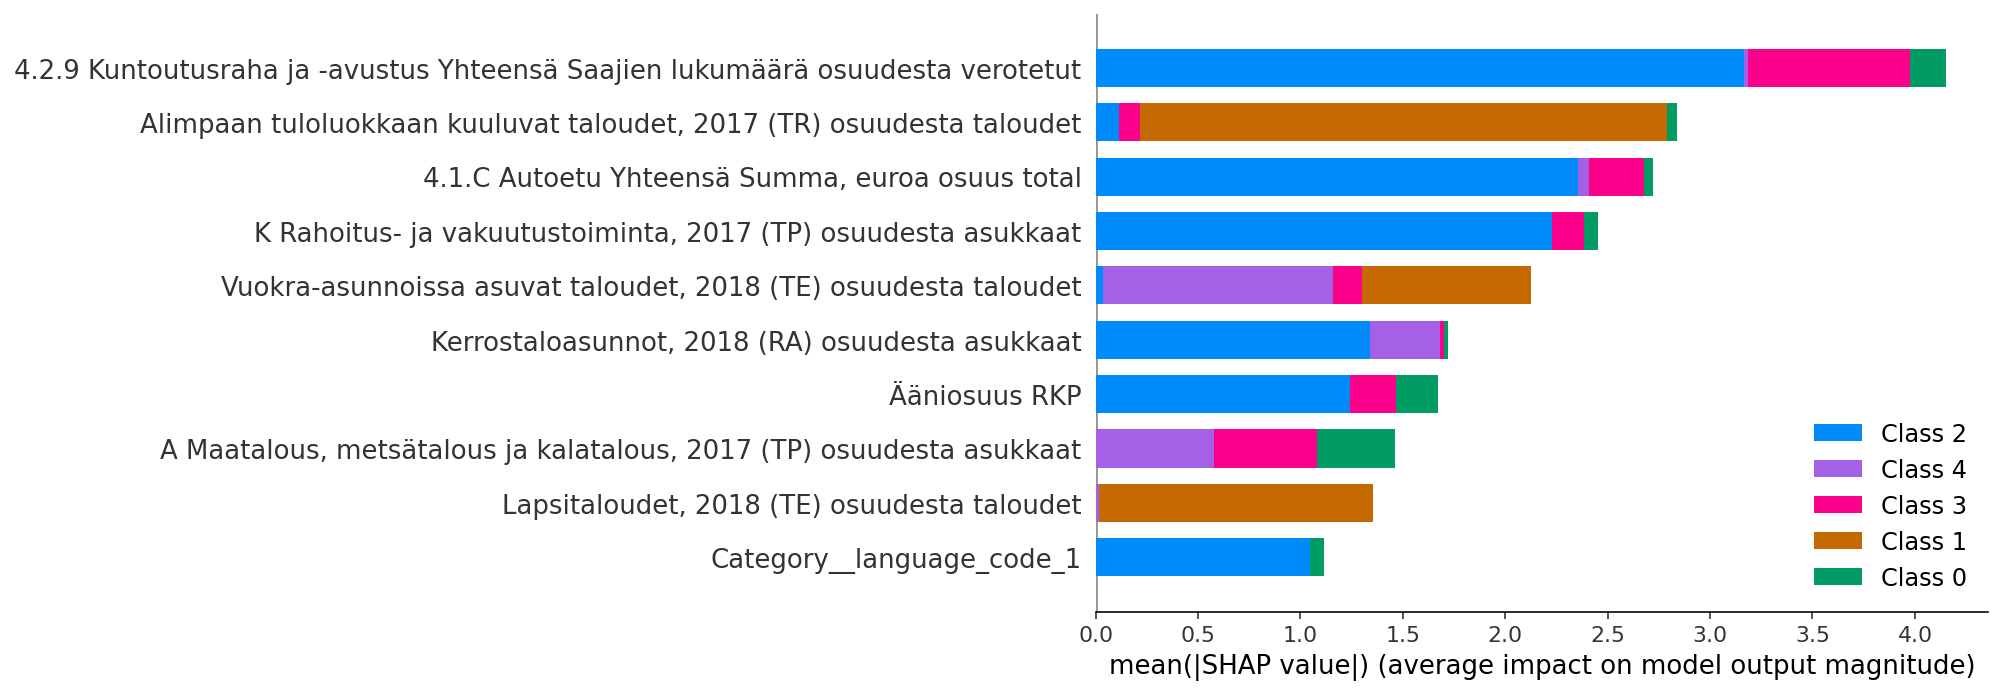

In [12]:
shap.summary_plot(shap_values, X,  max_display=10)

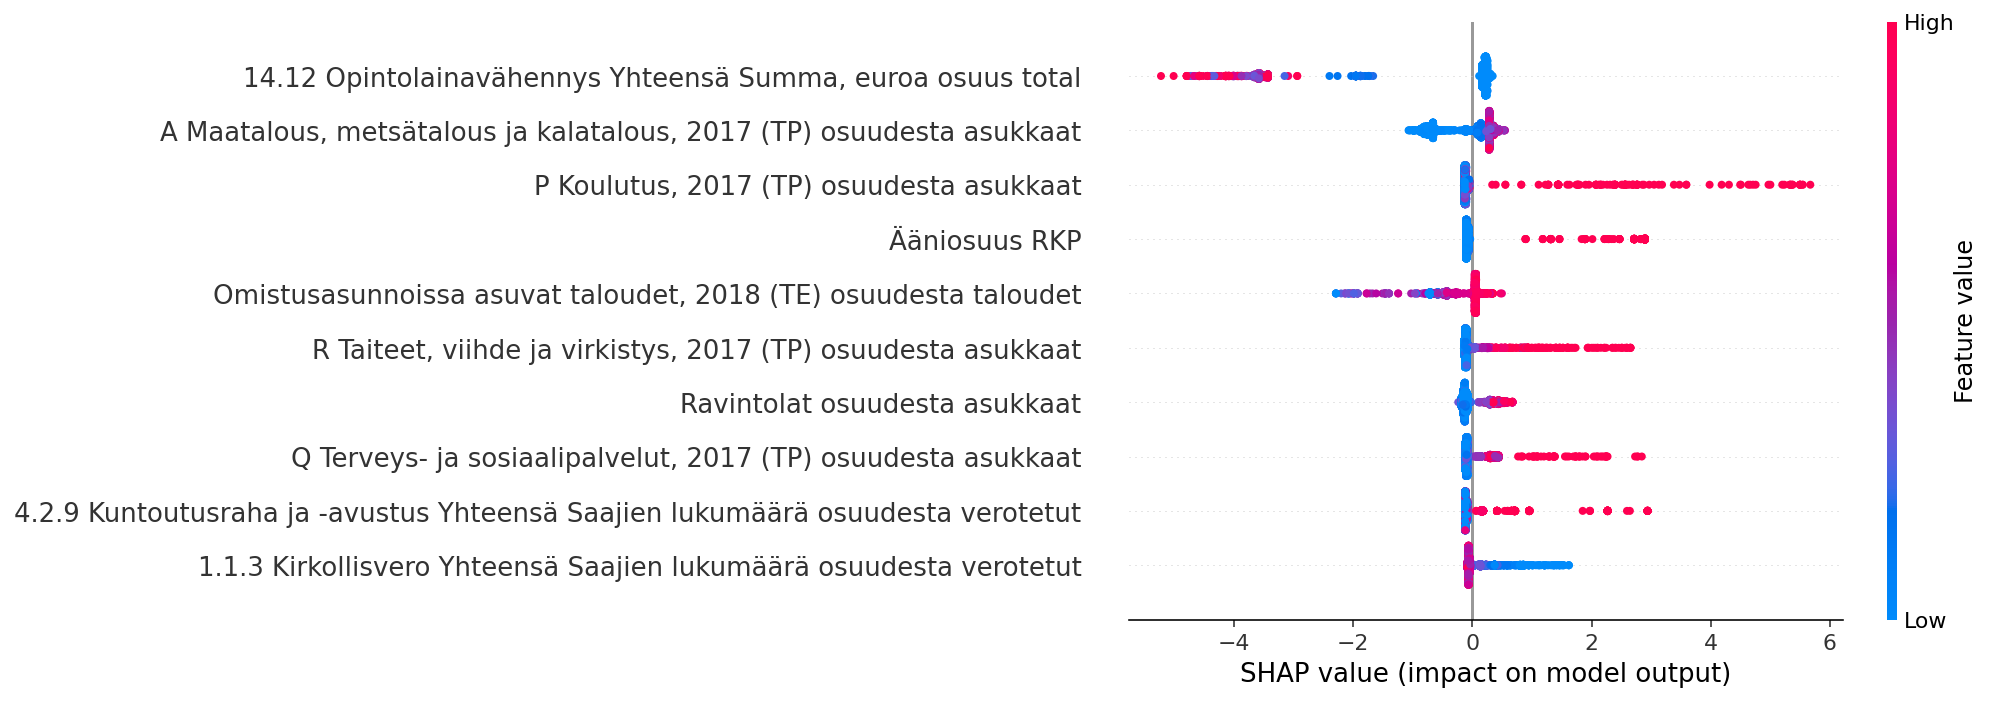

In [13]:
shap_index = 0
included_columns = []
columns = 10
scaled = False

compare_to = data[(data['cluster']) == shap_index].copy()
compare_to = create_share_of_values(compare_to)
compare_to = create_new_values(compare_to, vaalidata)

shap.summary_plot(shap_values[shap_index], X,  max_display=columns)

invalid value encountered in true_divide
invalid value encountered in true_divide


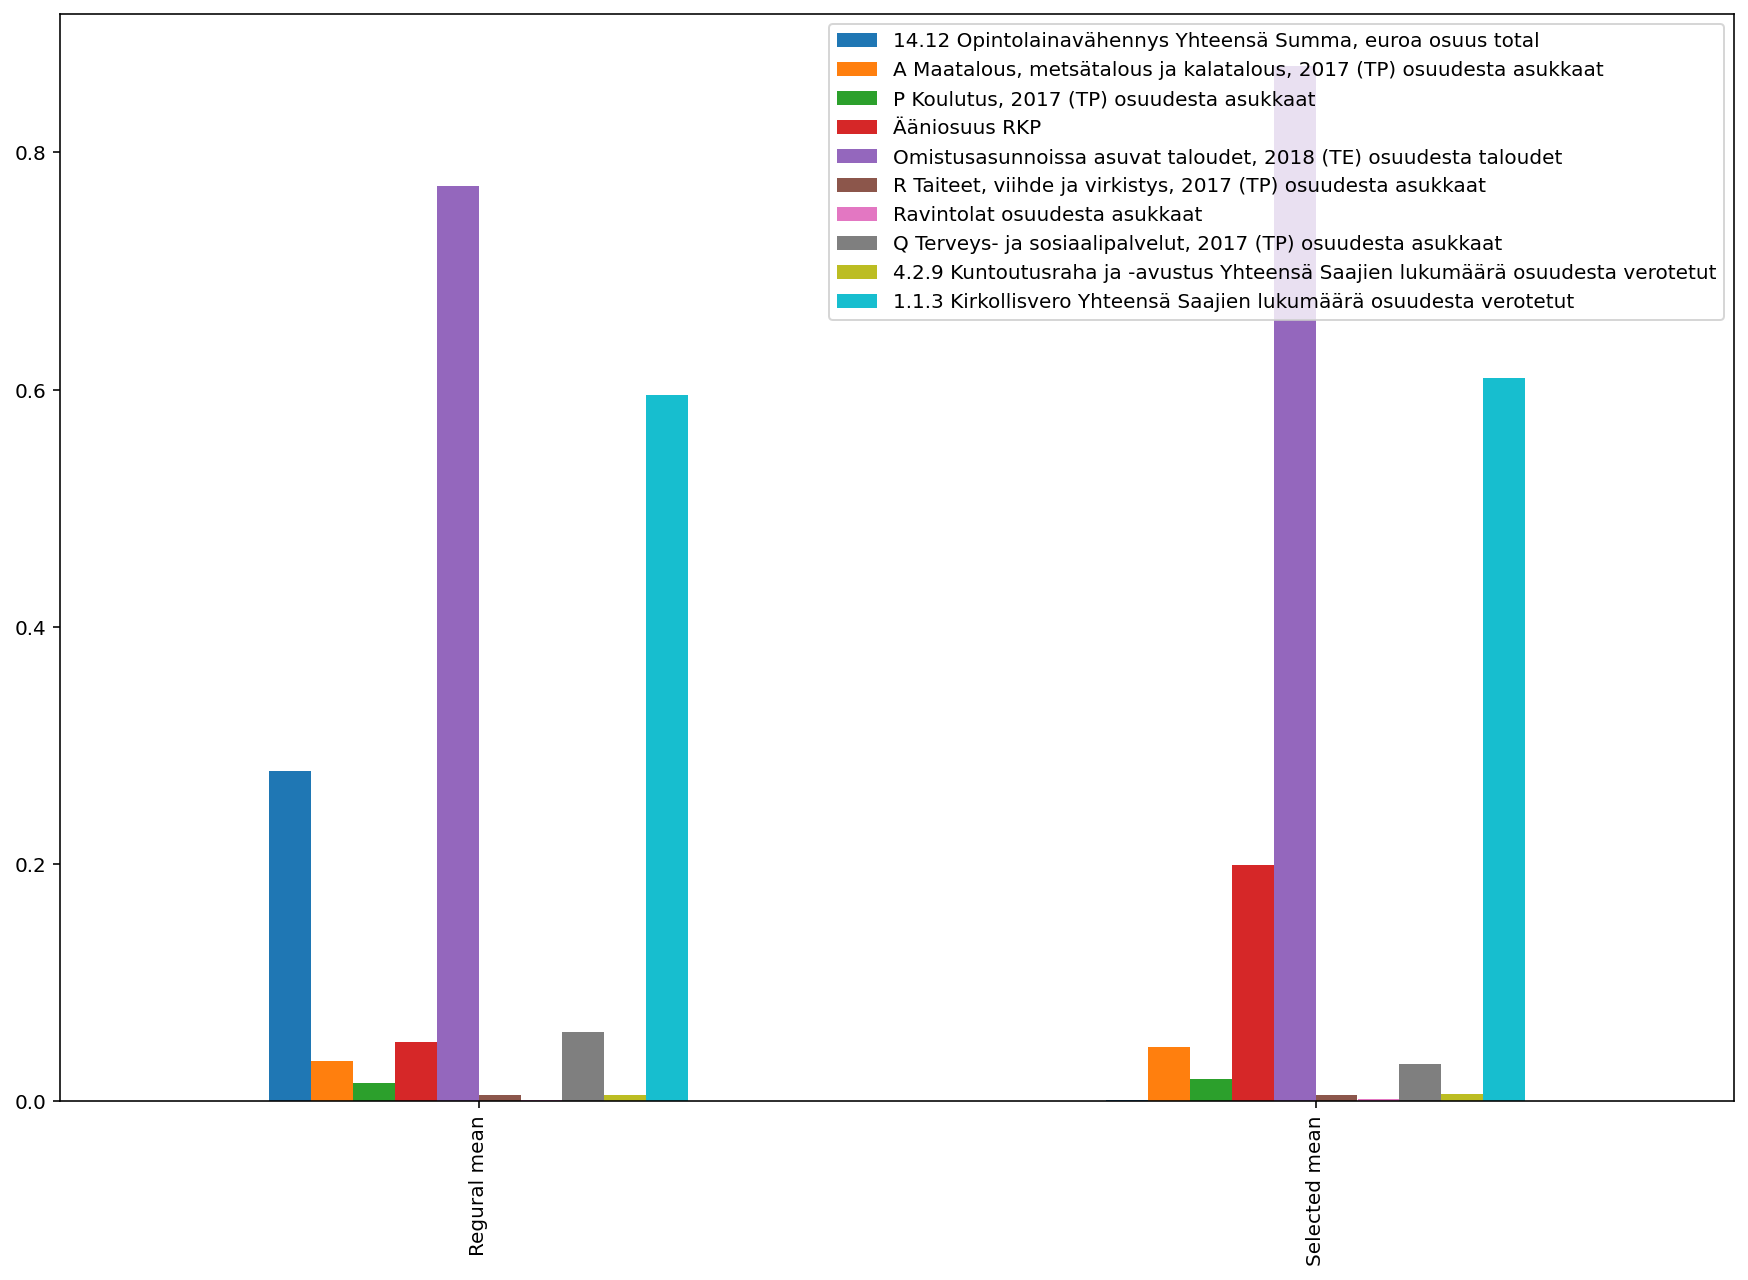

In [14]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=columns, scaled=scaled)

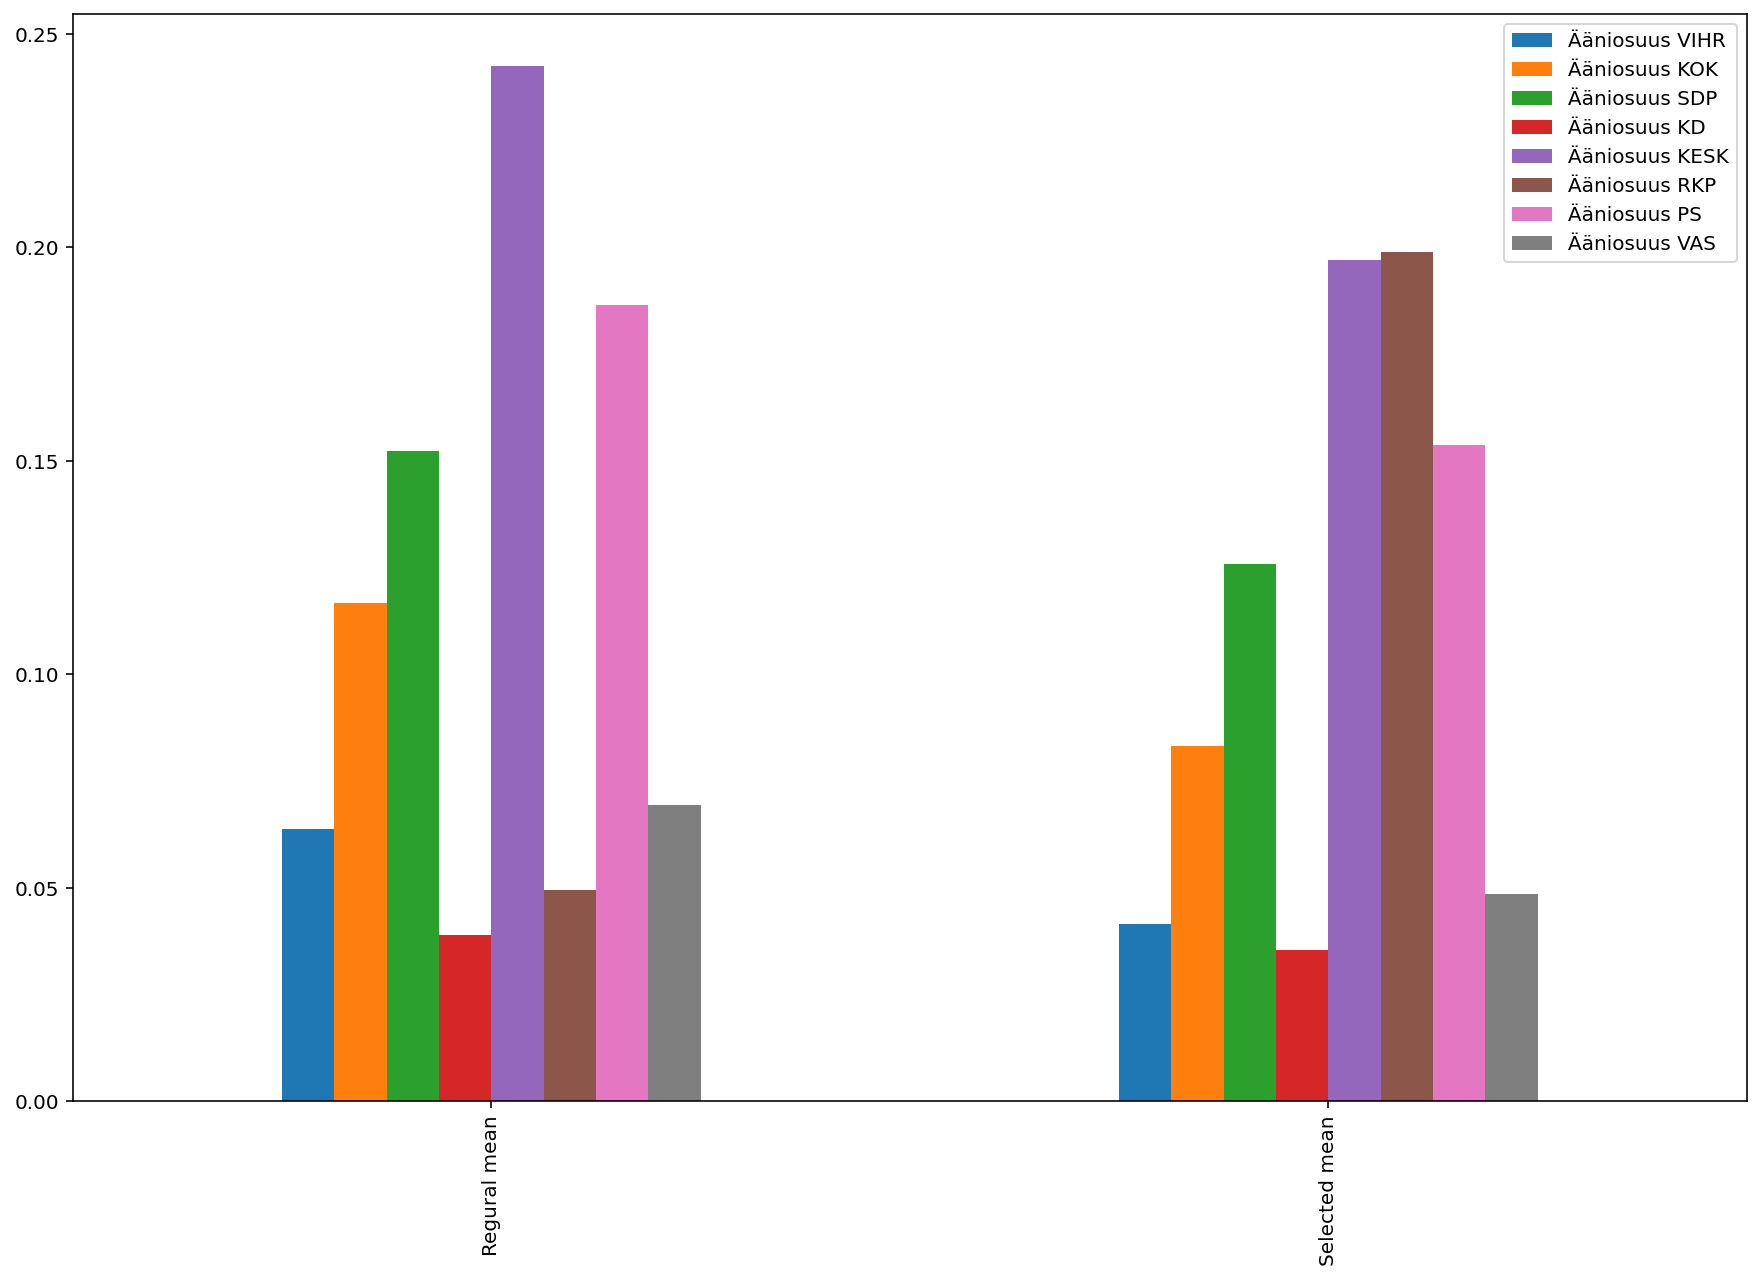

In [15]:
included_columns = all_included_columns
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=0, scaled=False)

In [16]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=columns)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
340        07990   RUOTSINKYLÄ          Loviisa                         278.0   
1763       66340     SARVIJOKI          Kurikka                         330.0   
1239       41390        ÄIJÄLÄ           Laukaa                         413.0   
1894       64210         KALAX           Närpes                         429.0   
2535       88380     MIESLAHTI          Paltamo                         229.0   

     Suurin_puolue  \
340           KESK   
1763          KESK   
1239          KESK   
1894           RKP   
2535          KESK   

      A Maatalous, metsätalous ja kalatalous, 2017 (TP) osuudesta asukkaat  \
340                                                               0.097122   
1763                                                              0.009091   
1239                                                              0.036320   
1894                                                              0.025641   
2535                                                              0.017467   

      P Koulutus, 2017 (TP) osuudesta asukkaat  \
340                                   0.017986   
1763                                  0.000000   
1239                                  0.012107   
1894                                  0.000000   
2535                                  0.122271   

      Q Terveys- ja sosiaalipalvelut, 2017 (TP) osuudesta asukkaat  \
340                                                       0.003597   
1763                                                      0.003030   
1239                                                      0.007264   
1894                                                      0.051282   
2535                                                      0.069869   

      R Taiteet, viihde ja virkistys, 2017 (TP) osuudesta asukkaat  \
340                                                       0.000000   
1763                                                      0.003030   
1239                                                      0.000000   
1894                                                      0.006993   
2535                                                      0.000000   

      Ravintolat osuudesta asukkaat  \
340                        0.007194   
1763                       0.000000   
1239                       0.000000   
1894                       0.000000   
2535                       0.000000   

      Omistusasunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
340                                                          0.914062   
1763                                                         0.927632   
1239                                                         0.908046   
1894                                                         0.966480   
2535                                                         0.938776   

      1.1.3 Kirkollisvero Yhteensä Saajien lukumäärä osuudesta verotetut  \
340                                                             0.594595   
1763                                                            0.546816   
1239                                                            0.533333   
1894                                                            0.703209   
2535                                                            0.611702   

      4.2.9 Kuntoutusraha ja -avustus Yhteensä Saajien lukumäärä osuudesta verotetut  \
340                                                                         0.000000   
1763                                                                        0.000000   
1239                                                                        0.033333   
1894                                                                        0.000000   
2535                                                                        0.000000   

      14.12 Opintolainavähennys Yhteensä Summa, euroa osuus total  \
340                                         

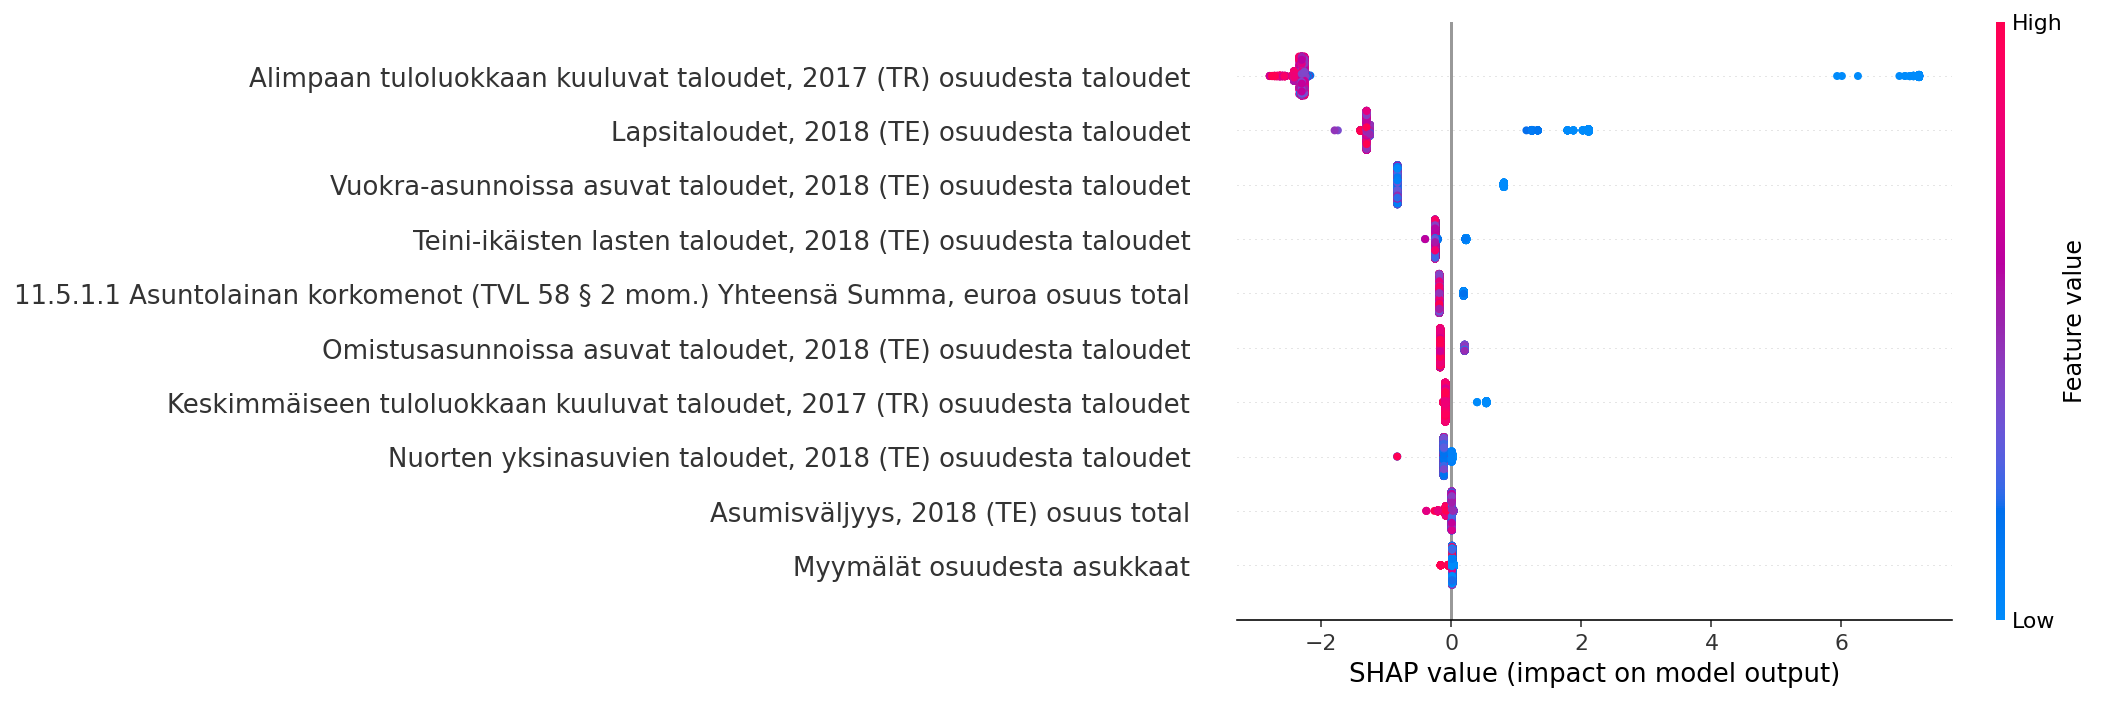

In [17]:
shap_index = 1
included_columns = []
columns = 10
scaled = False

compare_to = data[(data['cluster']) == shap_index].copy()
compare_to = create_share_of_values(compare_to)
compare_to = create_new_values(compare_to, vaalidata)

shap.summary_plot(shap_values[shap_index], X,  max_display=columns)

invalid value encountered in true_divide
invalid value encountered in true_divide


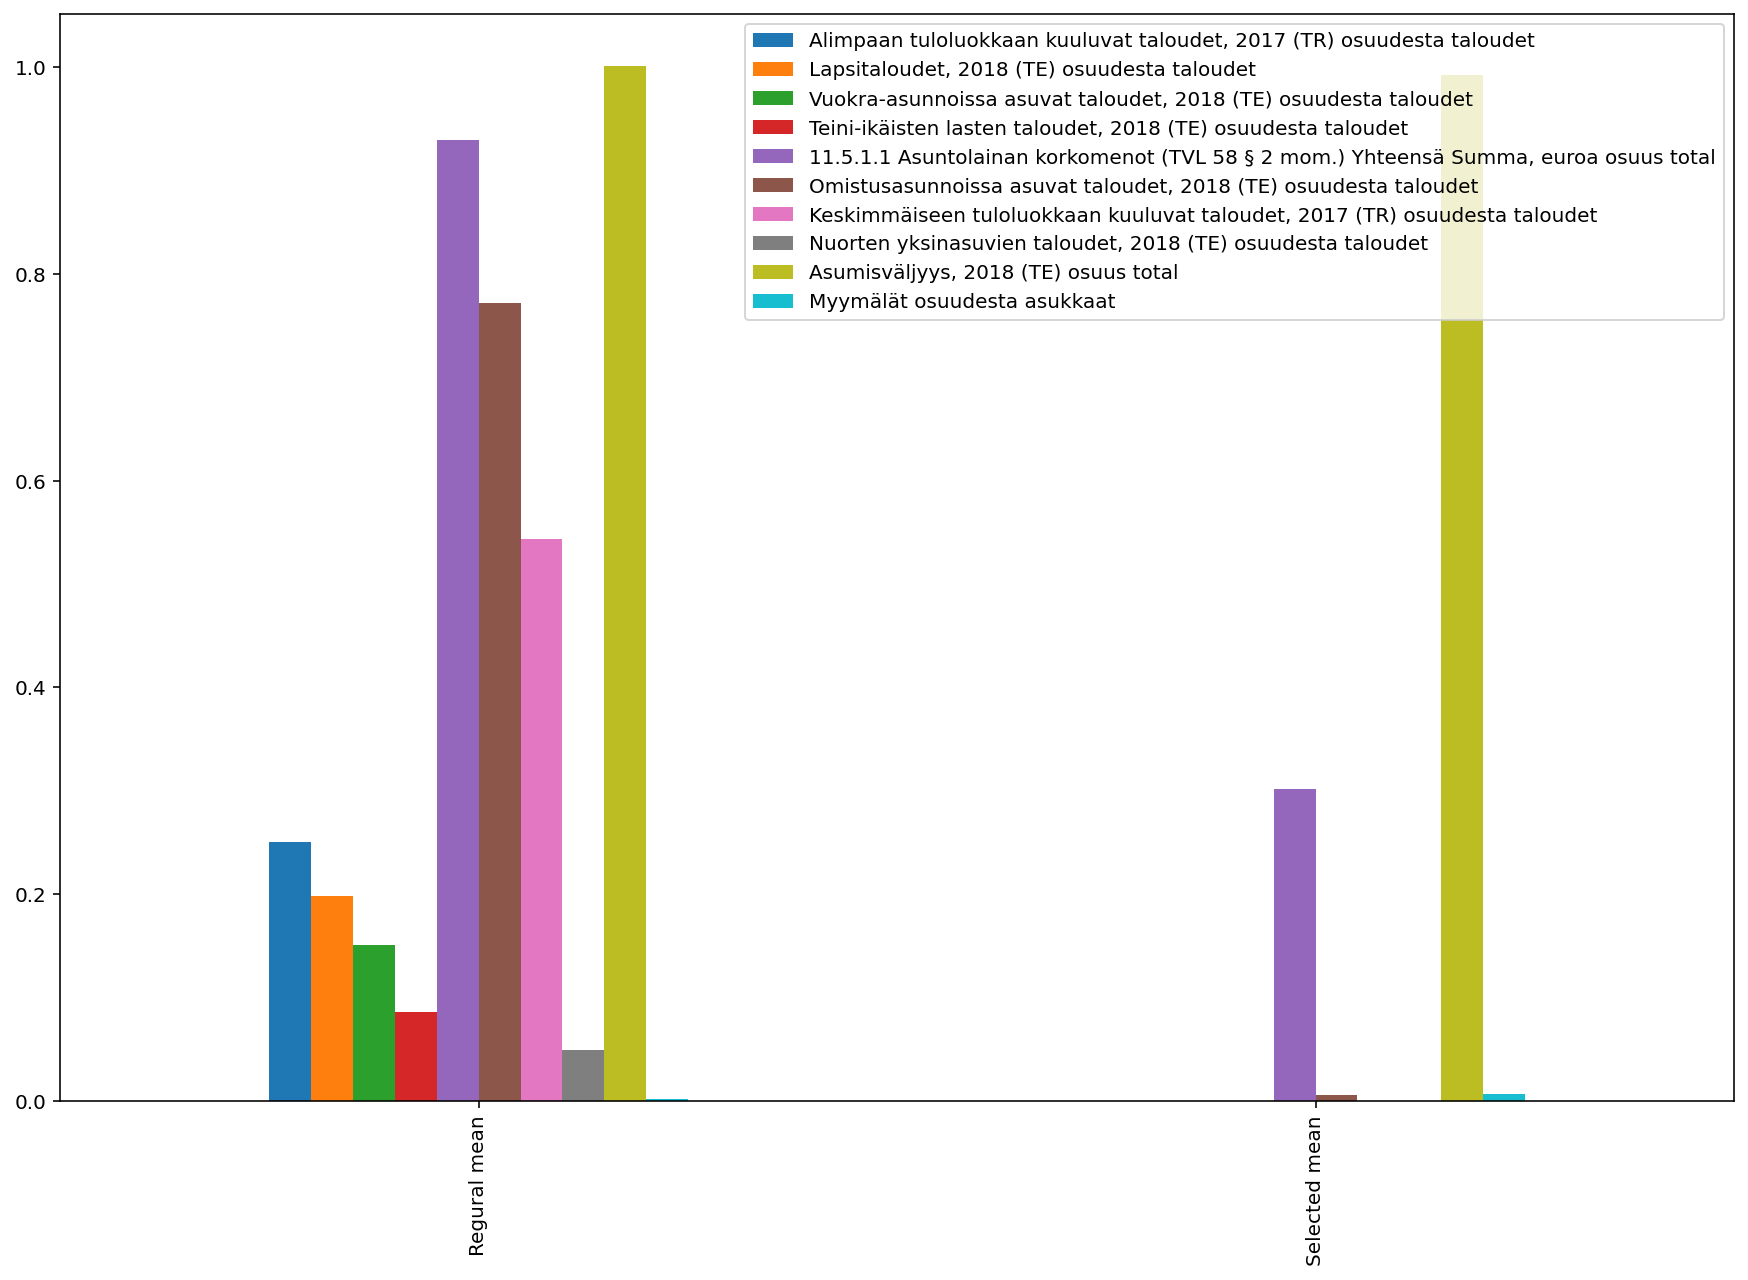

In [18]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=columns, scaled=scaled)

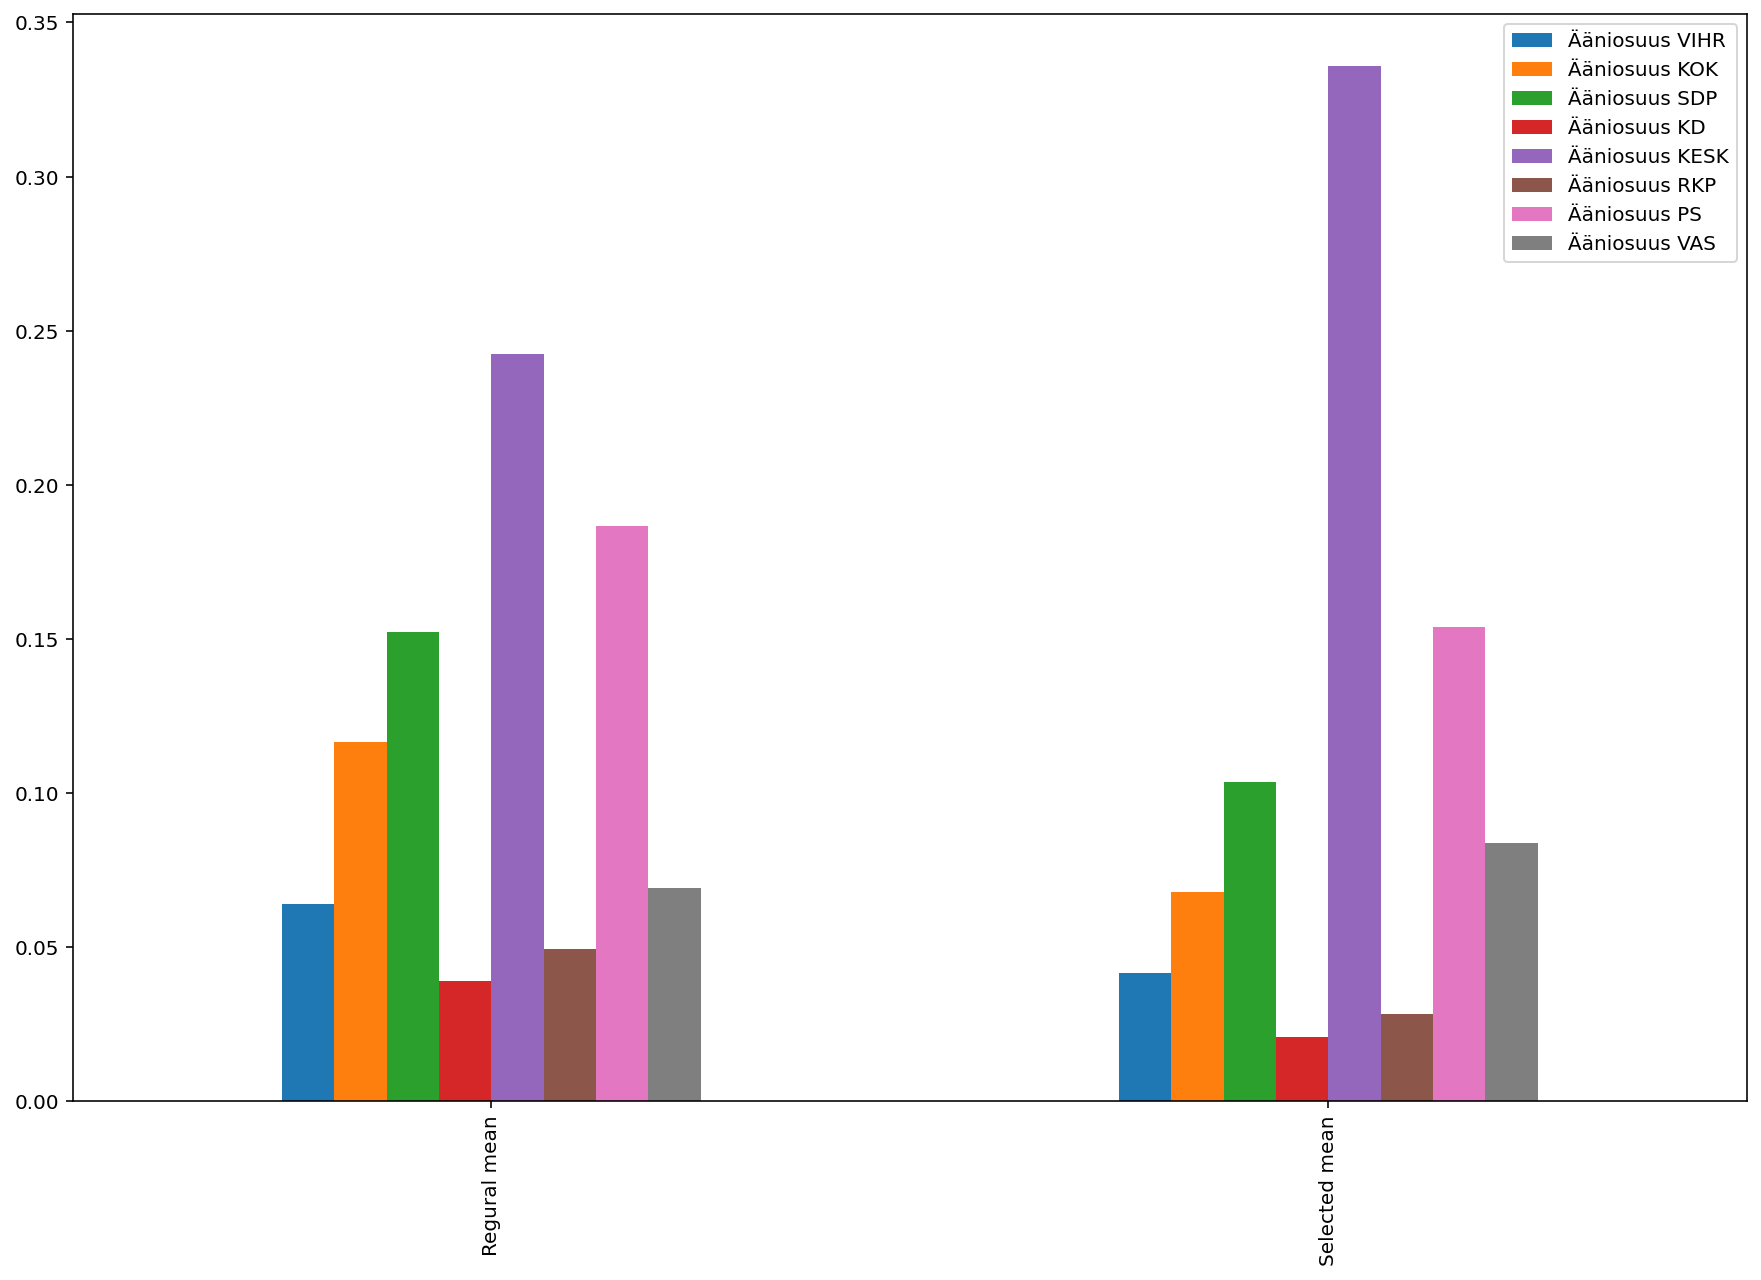

In [19]:
included_columns = all_included_columns
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=0, scaled=False)

In [20]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=columns)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
2192       73970     RIITASALO       Rautavaara                           8.0   
1398       54580    SOMERHARJU          Luumäki                          37.0   
2145       79230     MONINMÄKI       Leppävirta                          58.0   
1370       46570      SAARAMAA          Kouvola                          36.0   
716        22950         JURMO           Brändö                          44.0   

     Suurin_puolue  Asumisväljyys, 2018 (TE) osuus total  \
2192          KESK                              1.010573   
1398          KESK                              1.098068   
2145          KESK                              1.025884   
1370          KESK                              0.971200   
716            RKP                              1.041196   

      Myymälät osuudesta asukkaat  \
2192                     0.000000   
1398                     0.000000   
2145                     0.000000   
1370                     0.027778   
716                      0.022727   

      Nuorten yksinasuvien taloudet, 2018 (TE) osuudesta taloudet  \
2192                                                          0.0   
1398                                                          0.0   
2145                                                          0.0   
1370                                                          0.0   
716                                                           0.0   

      Lapsitaloudet, 2018 (TE) osuudesta taloudet  \
2192                                          0.0   
1398                                          0.0   
2145                                          0.0   
1370                                          0.0   
716                                           0.0   

      Teini-ikäisten lasten taloudet, 2018 (TE) osuudesta taloudet  \
2192                                                           0.0   
1398                                                           0.0   
2145                                                           0.0   
1370                                                           0.0   
716                                                            0.0   

      Omistusasunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
2192                                                              0.0   
1398                                                              0.0   
2145                                                              0.0   
1370                                                              0.0   
716                                                               0.0   

      Vuokra-asunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
2192                                                              0.0   
1398                                                              0.0   
2145                                                              0.0   
1370                                                              0.0   
716                                                               0.0   

      Alimpaan tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  \
2192                                                                    0.0   
1398                                                                    0.0   
2145                                                                    0.0   
1370                                                                    0.0   
716                                                                     0.0   

      Keskimmäiseen tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  \
2192                                                                         0.0   
1398                                                                         0.0   
2145                                                                         0.0   
1370                                                                         0.0   
716   

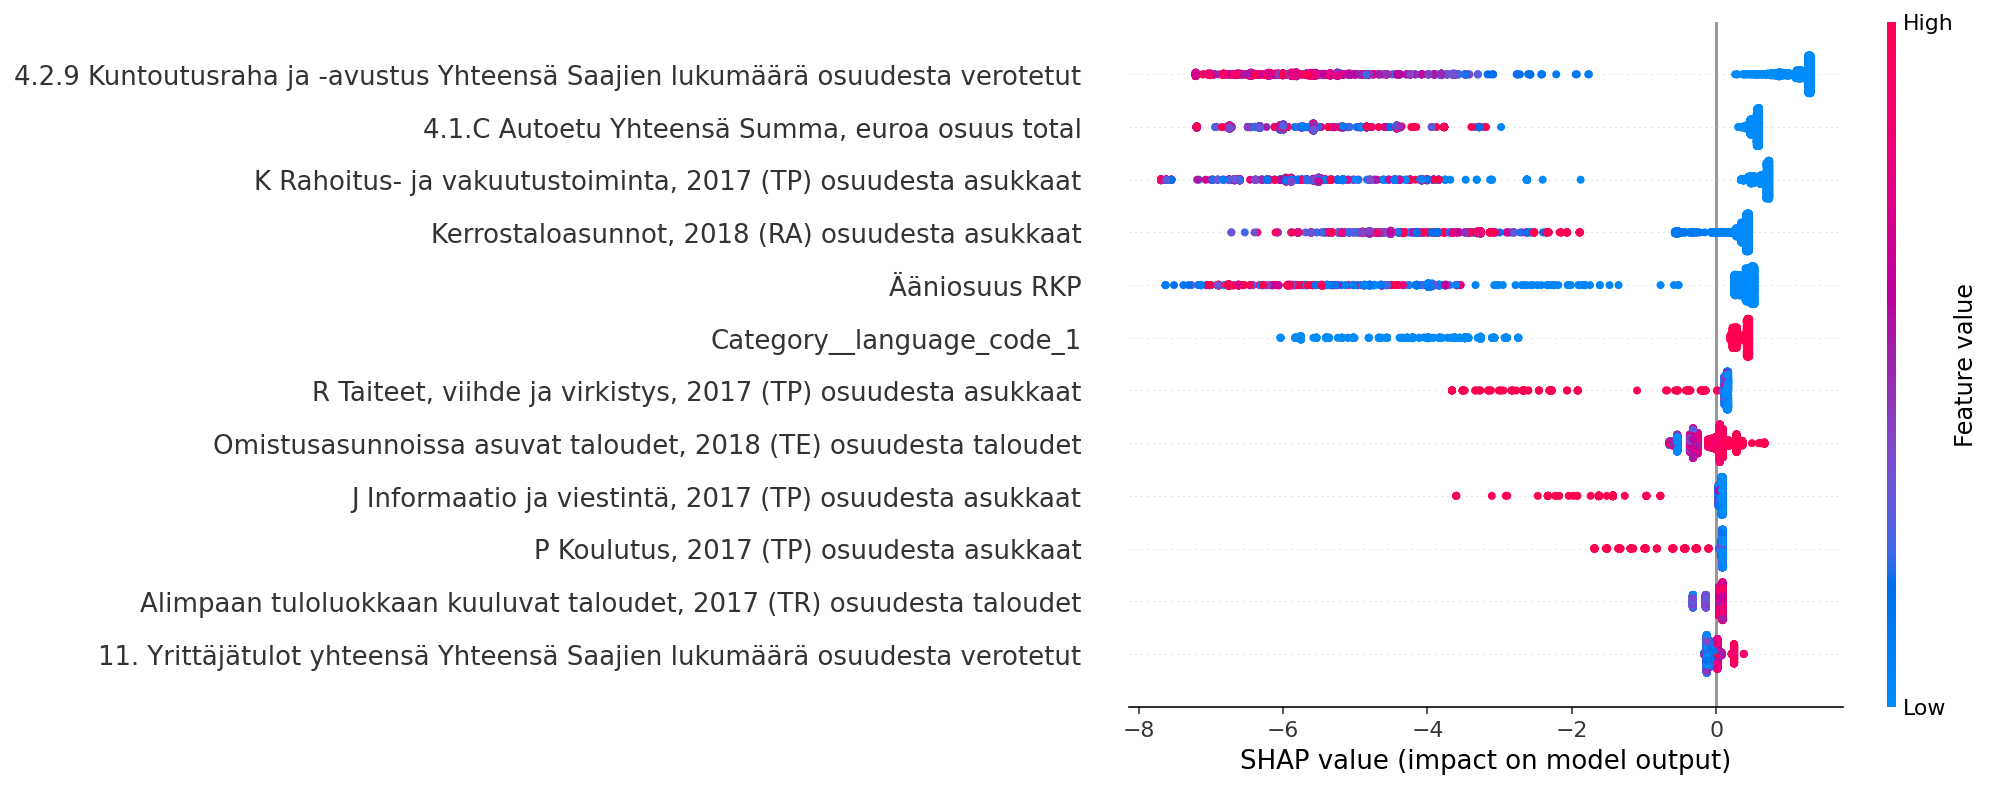

In [21]:
shap_index = 2
included_columns = []
columns = 12
scaled = False

compare_to = data[(data['cluster']) == shap_index].copy()
compare_to = create_share_of_values(compare_to)
compare_to = create_new_values(compare_to, vaalidata)

shap.summary_plot(shap_values[shap_index], X,  max_display=columns)

invalid value encountered in true_divide
invalid value encountered in true_divide


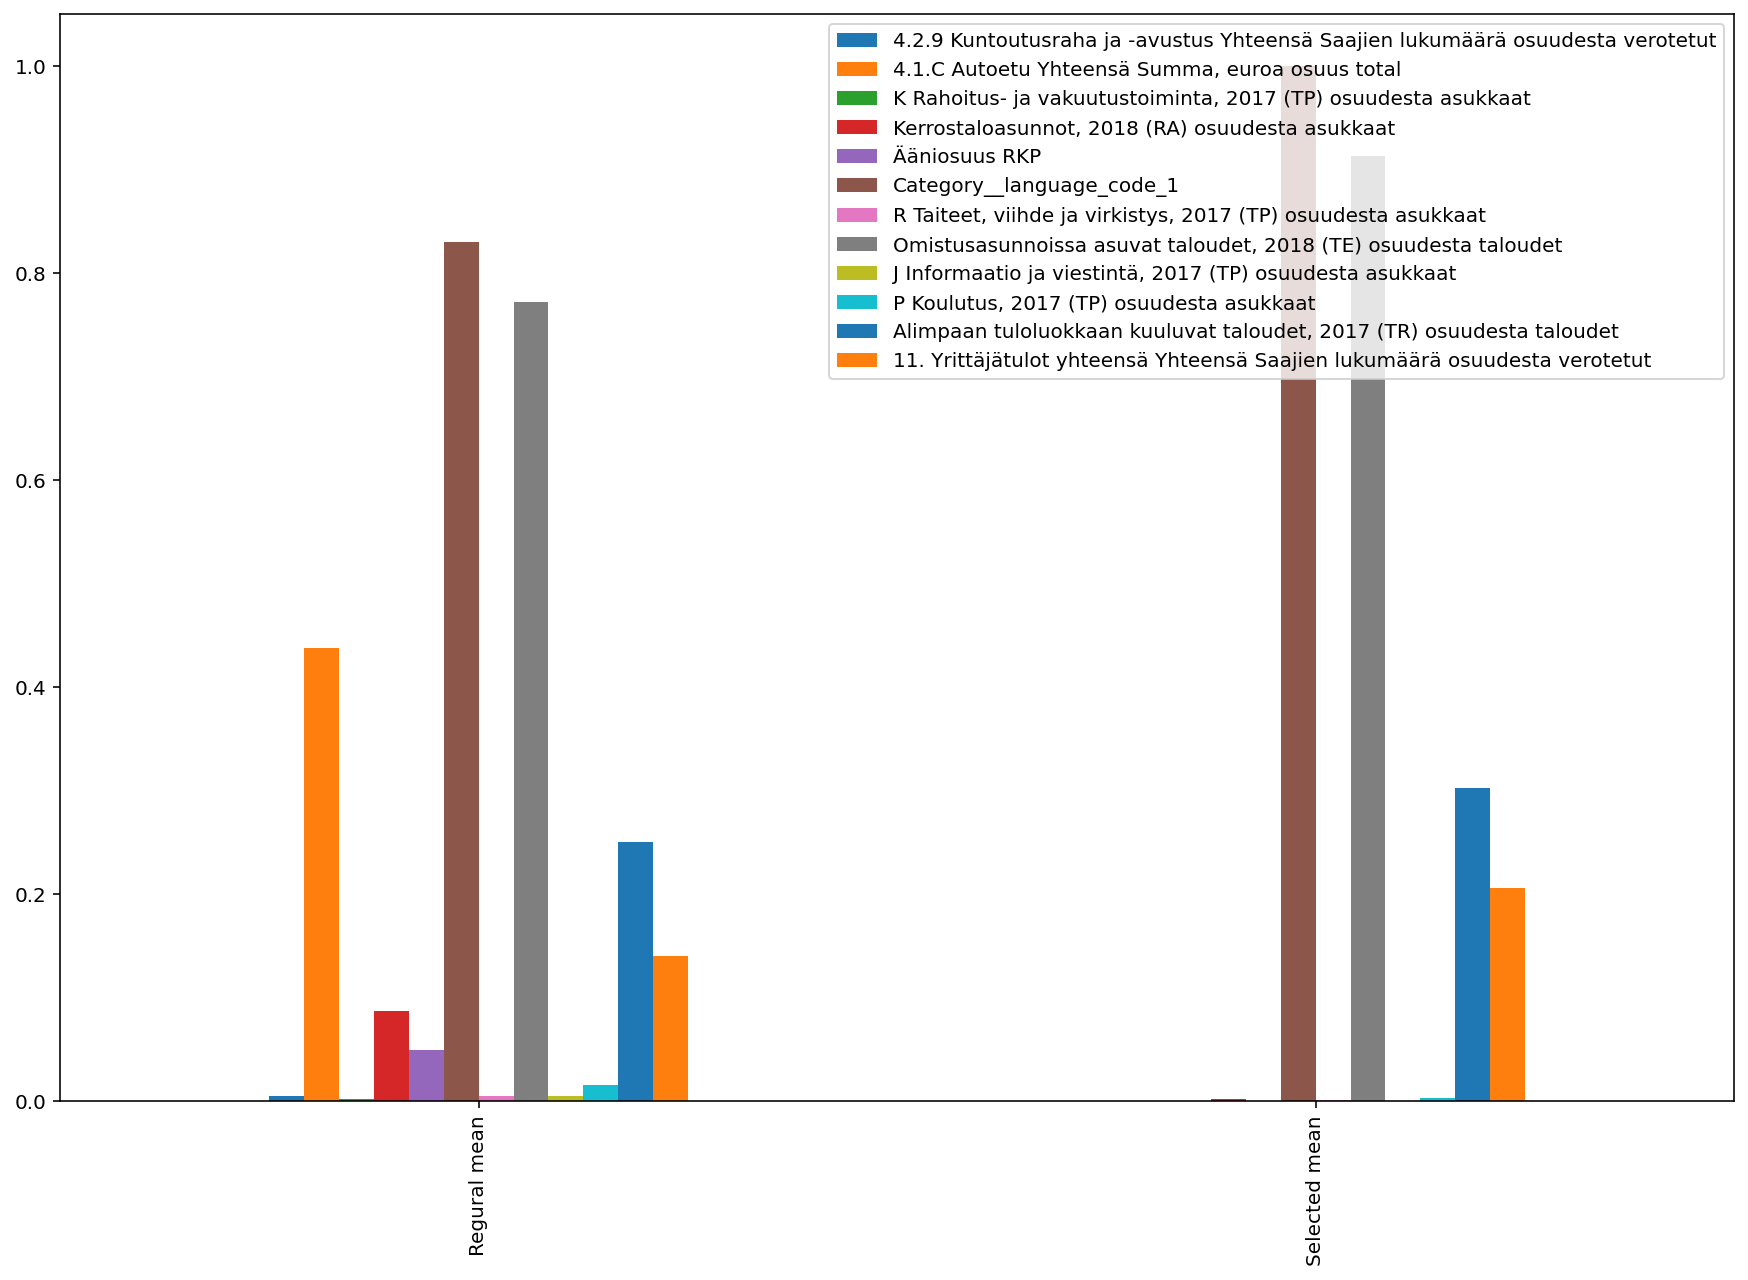

In [22]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=columns, scaled=scaled)

invalid value encountered in true_divide
invalid value encountered in true_divide


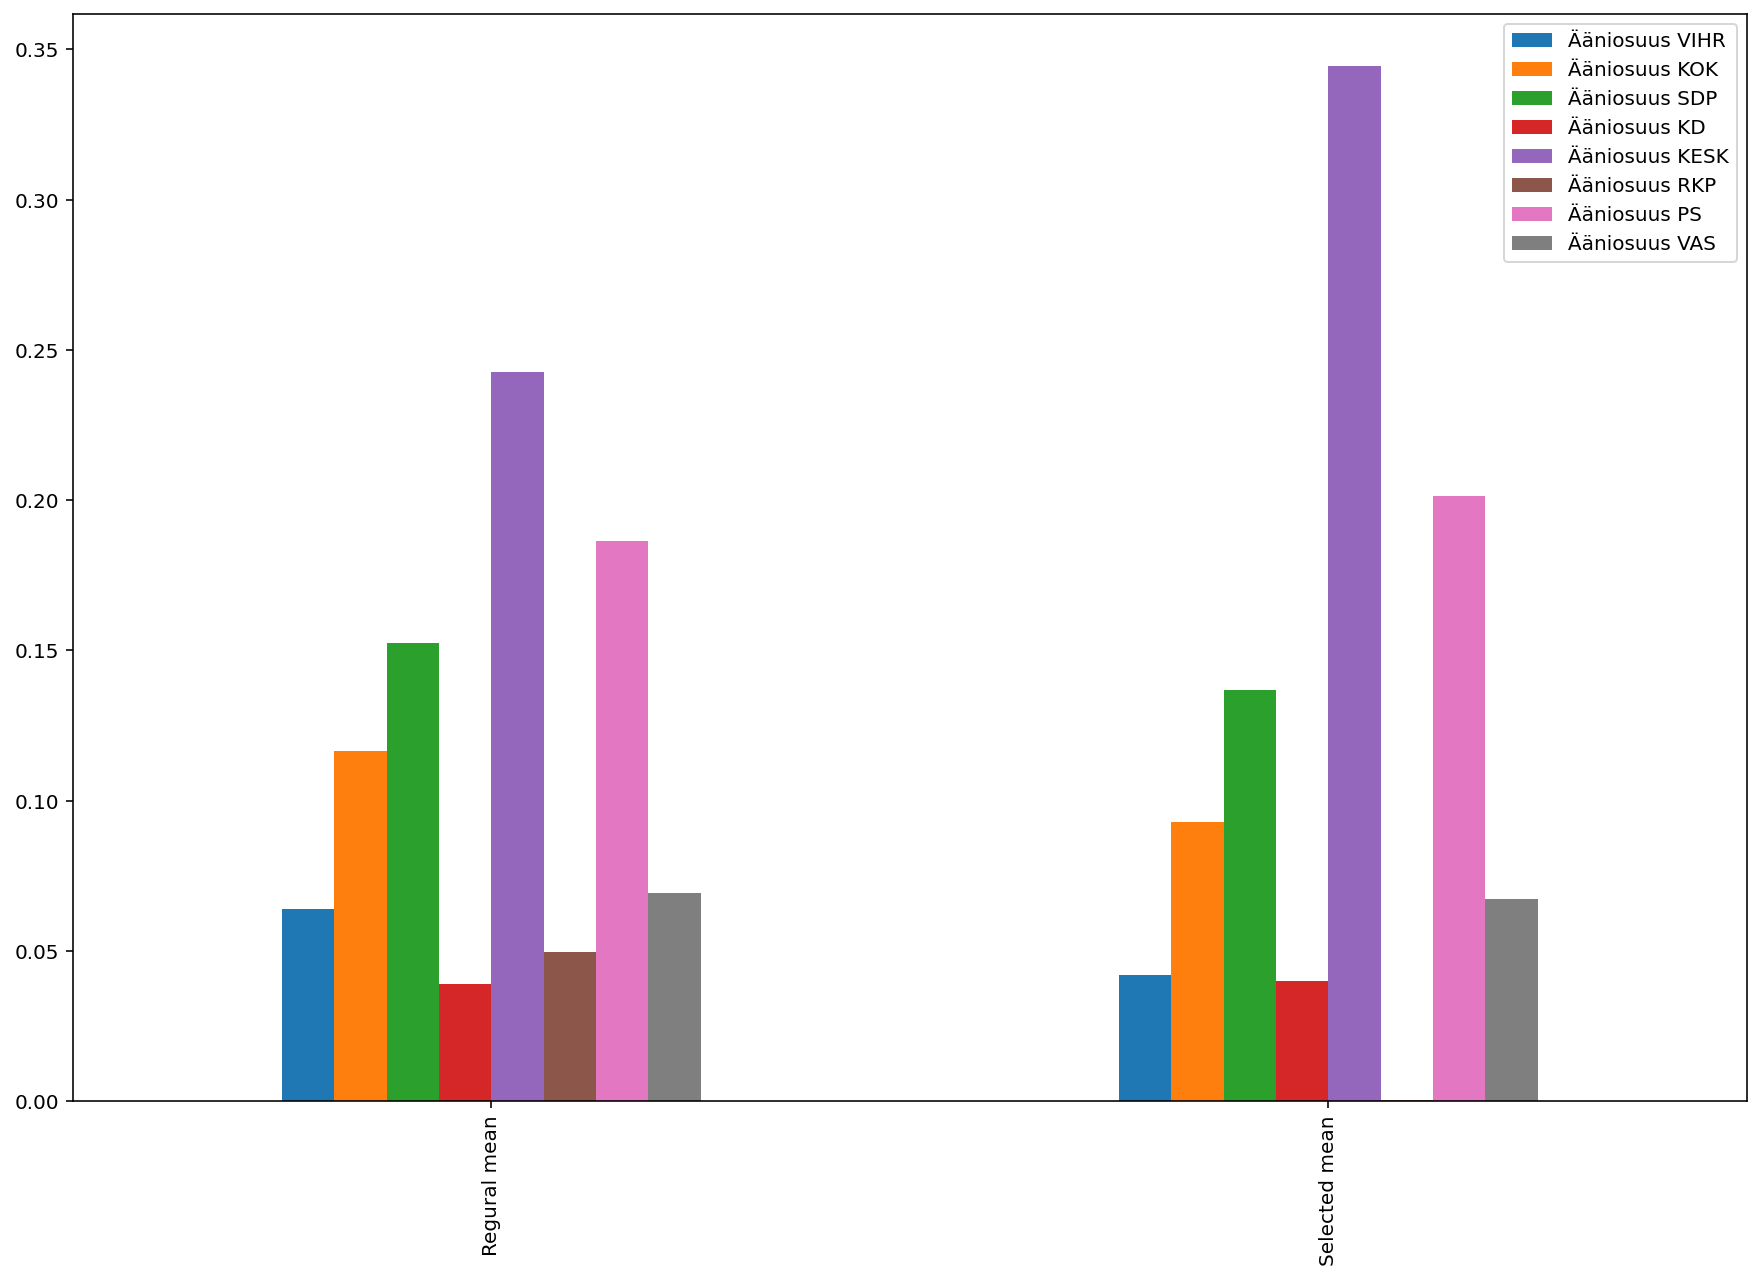

In [23]:
included_columns = all_included_columns
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=0, scaled=False)

In [24]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=columns)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
2141       79150   KONNUSLAHTI       Leppävirta                         391.0   
1254       43270       KALMARI       Saarijärvi                         490.0   
827        27670       MANNILA             Eura                         157.0   
2237       74770    KALLIOKYLÄ        Kiuruvesi                          66.0   
2539       91710       JYLHÄMÄ            Vaala                          56.0   

     Suurin_puolue  Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat  \
2141          KESK                                         0.000000   
1254          KESK                                         0.010204   
827           KESK                                         0.000000   
2237          KESK                                         0.000000   
2539          KESK                                         0.000000   

      J Informaatio ja viestintä, 2017 (TP) osuudesta asukkaat  \
2141                                                  0.002558   
1254                                                  0.002041   
827                                                   0.000000   
2237                                                  0.000000   
2539                                                  0.000000   

      K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta asukkaat  \
2141                                                            0.0   
1254                                                            0.0   
827                                                             0.0   
2237                                                            0.0   
2539                                                            0.0   

      P Koulutus, 2017 (TP) osuudesta asukkaat  \
2141                                  0.012788   
1254                                  0.000000   
827                                   0.000000   
2237                                  0.060606   
2539                                  0.000000   

      R Taiteet, viihde ja virkistys, 2017 (TP) osuudesta asukkaat  \
2141                                                           0.0   
1254                                                           0.0   
827                                                            0.0   
2237                                                           0.0   
2539                                                           0.0   

      Omistusasunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
2141                                                         0.934911   
1254                                                         0.831858   
827                                                          0.987013   
2237                                                         0.000000   
2539                                                         0.848485   

      Alimpaan tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  \
2141                                                               0.207101   
1254                                                               0.323009   
827                                                                0.285714   
2237                                                               0.551724   
2539                                                               0.363636   

      11. Yrittäjätulot yhteensä Yhteensä Saajien lukumäärä osuudesta verotetut  \
2141                                                                   0.282738   
1254                                                                   0.247312   
827                                                                    0.211268   
2237                                                                   0.306122   
2539                                                                   0.000000   

      4.2.9 Kuntoutusraha ja -avustus Yhteensä Saajien lukumäärä osuudesta verotetut  \
2141                                        

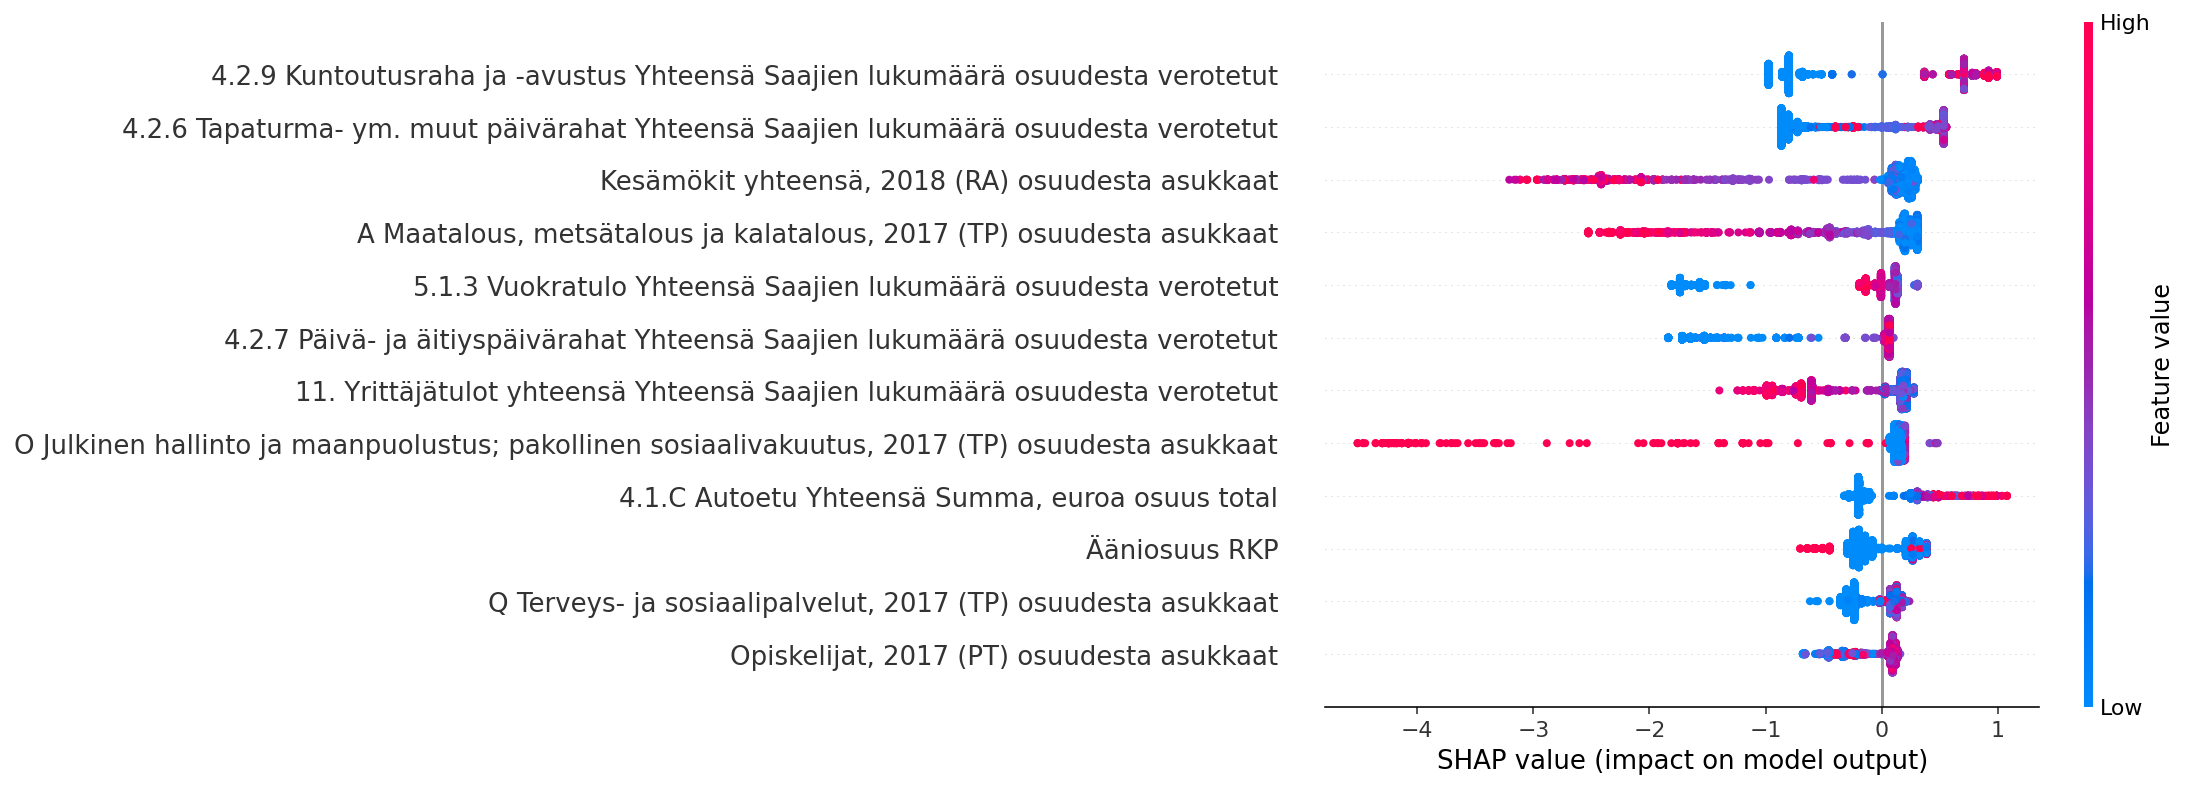

In [25]:
shap_index = 3
included_columns = []
columns = 12
scaled = False

compare_to = data[(data['cluster']) == shap_index].copy()
compare_to = create_share_of_values(compare_to)
compare_to = create_new_values(compare_to, vaalidata)

shap.summary_plot(shap_values[shap_index], X,  max_display=columns)

invalid value encountered in true_divide
invalid value encountered in true_divide


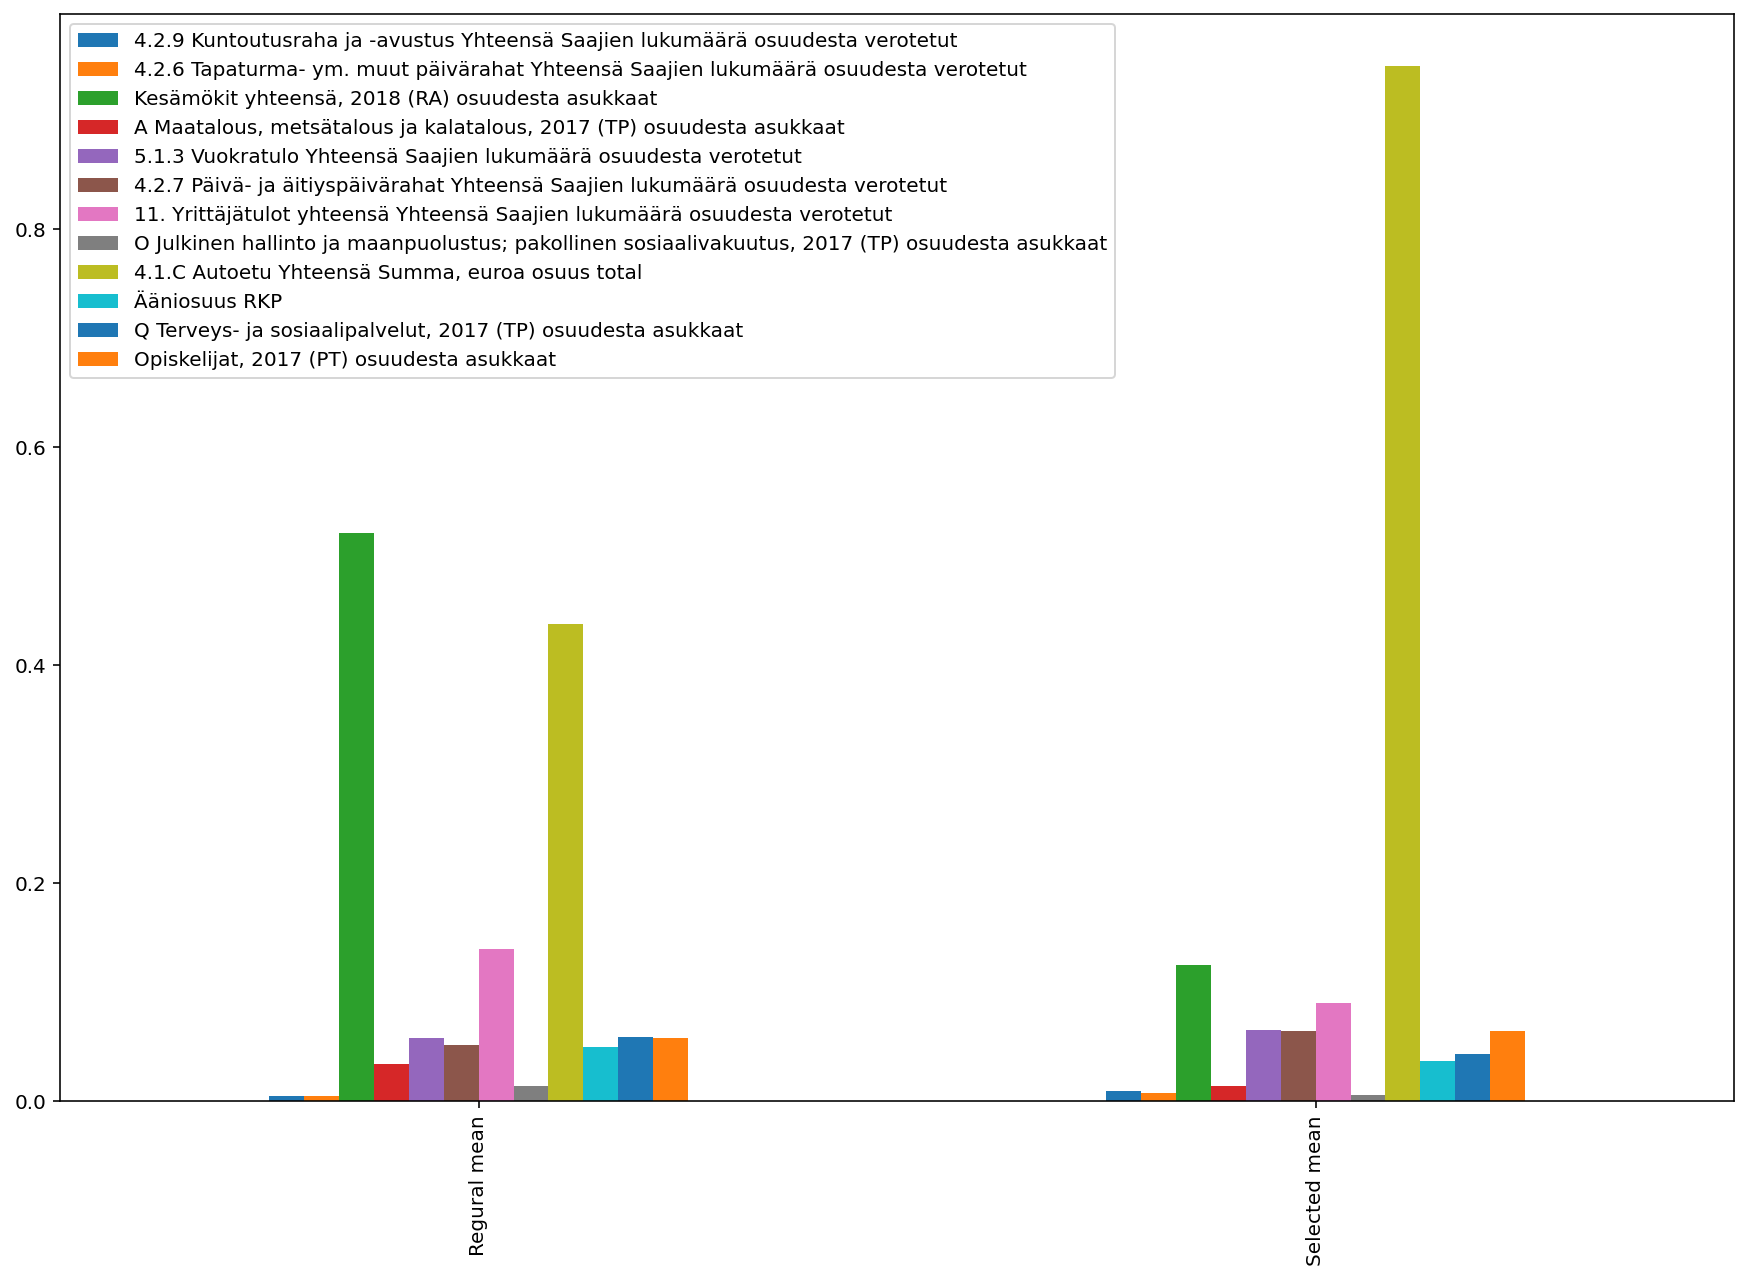

In [26]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=columns, scaled=scaled)

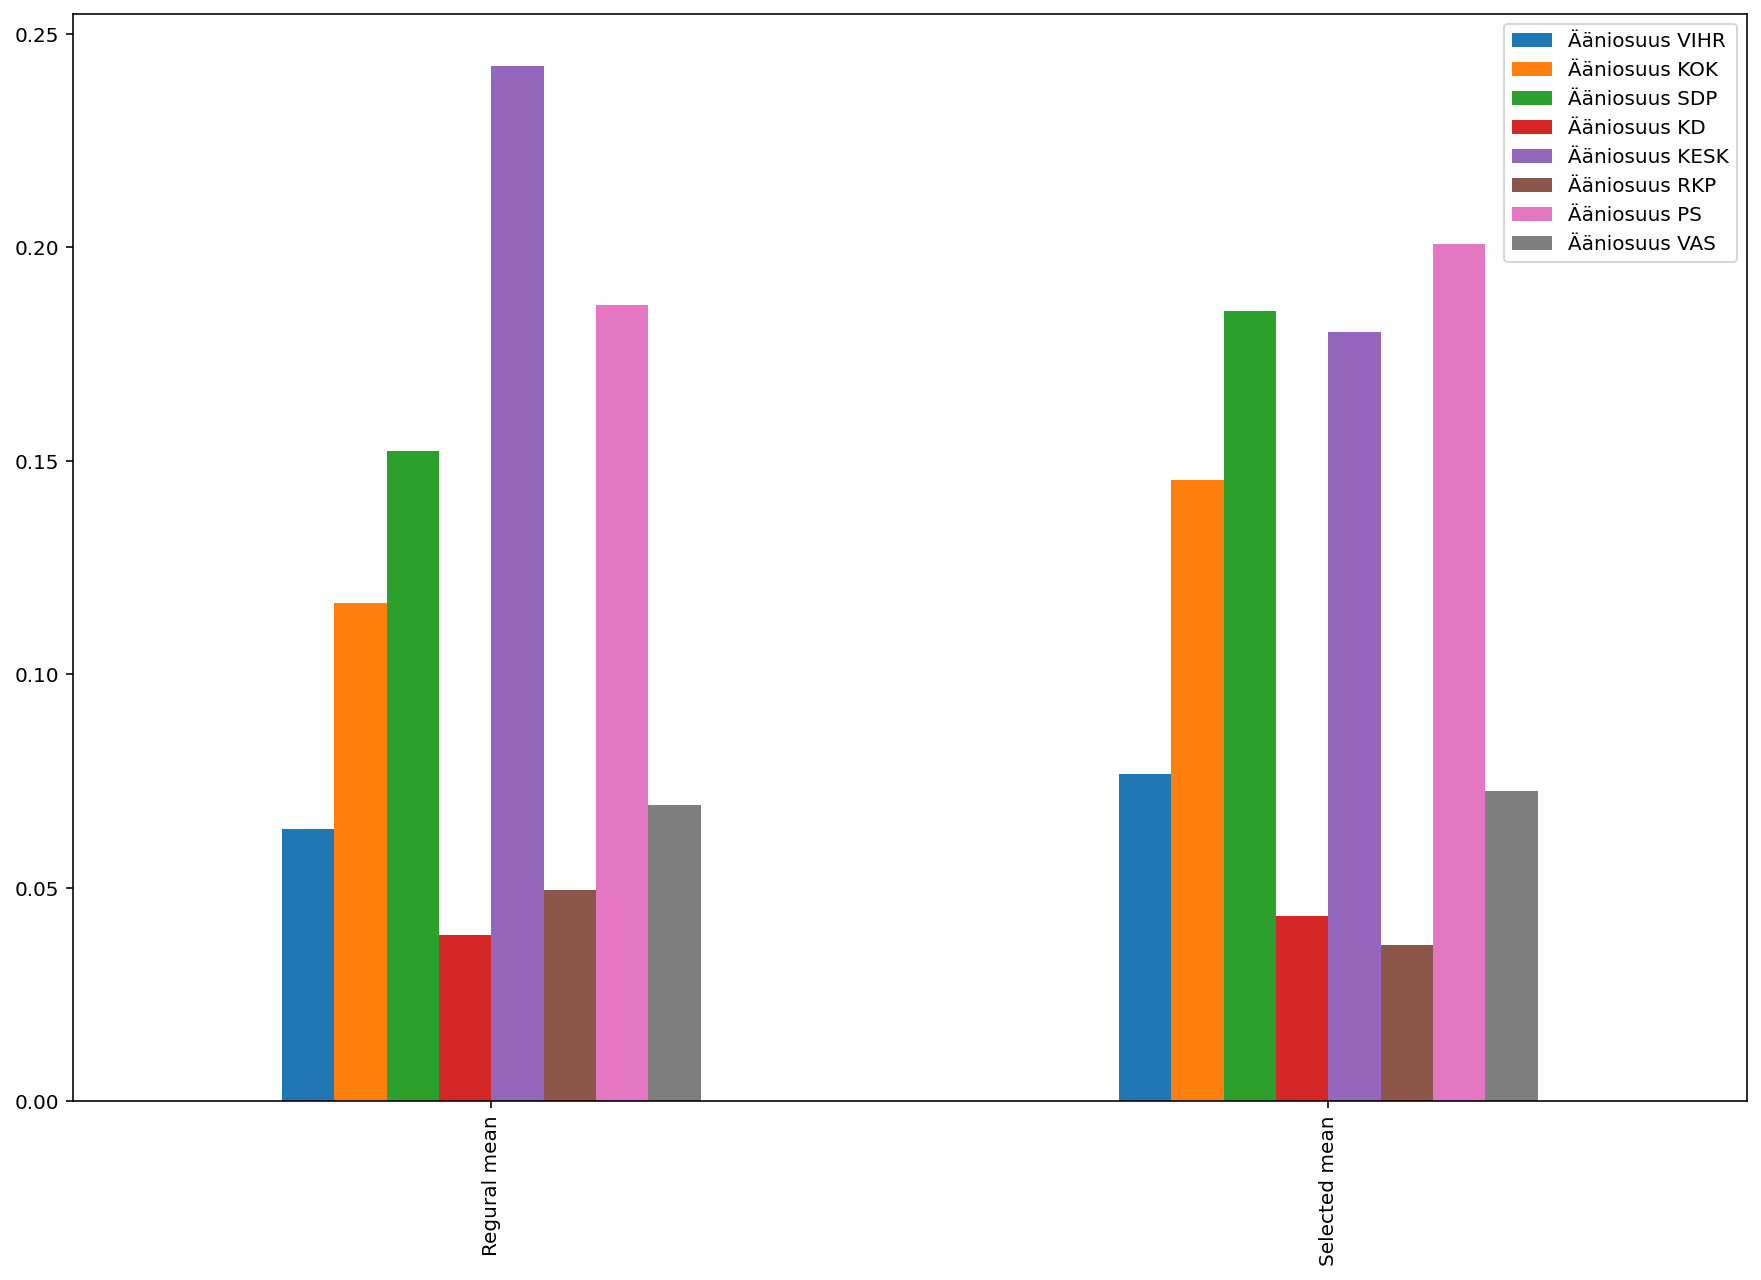

In [27]:
included_columns = all_included_columns
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=0, scaled=False)

In [28]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=columns)
new_df.sample(5)

Postinumero  postcode_name muncipality_name  \
2597       90460      OULUNSALO             Oulu   
1905       64260       KASKINEN         Kaskinen   
1790       62100          LAPUA            Lapua   
425        14200        TURENKI        Janakkala   
1262       41500  HANKASALMI AS       Hankasalmi   

      Asukkaat yhteensä, 2018 (HE) Suurin_puolue  \
2597                        8840.0          KESK   
1905                        1327.0           RKP   
1790                       10857.0           KOK   
425                         8661.0           SDP   
1262                        1341.0            PS   

      Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat  \
2597                                          0.025566   
1905                                          0.187641   
1790                                          0.015198   
425                                           0.061309   
1262                                          0.176734   

      Opiskelijat, 2017 (PT) osuudesta asukkaat  \
2597                                   0.085973   
1905                                   0.051243   
1790                                   0.062725   
425                                    0.065120   
1262                                   0.046980   

      A Maatalous, metsätalous ja kalatalous, 2017 (TP) osuudesta asukkaat  \
2597                                                              0.000792   
1905                                                              0.017332   
1790                                                              0.010961   
425                                                               0.010622   
1262                                                              0.018643   

      O Julkinen hallinto ja maanpuolustus; pakollinen sosiaalivakuutus, 2017 (TP) osuudesta asukkaat  \
2597                                                                                         0.000000   
1905                                                                                         0.018086   
1790                                                                                         0.015474   
425                                                                                          0.011892   
1262                                                                                         0.000000   

      Q Terveys- ja sosiaalipalvelut, 2017 (TP) osuudesta asukkaat  \
2597                                                      0.041176   
1905                                                      0.034665   
1790                                                      0.064198   
425                                                       0.067544   
1262                                                      0.021626   

      11. Yrittäjätulot yhteensä Yhteensä Saajien lukumäärä osuudesta verotetut  \
2597                                                                   0.060729   
1905                                                                   0.058824   
1790                                                                   0.099051   
425                                                                    0.063509   
1262                                                                   0.110044   

      4.2.6 Tapaturma- ym. muut päivärahat Yhteensä Saajien lukumäärä osuudesta verotetut  \
2597                                                                             0.007083   
1905                                                                             0.000000   
1790                                                                             0.007280   
425                                                                              0.008611   
1262                                                                             0.006987   

      4.2.7 Päivä- ja äitiyspäivärahat Yhteensä Saajien lukumäärä osuudesta verotetut  \
2597                                                   

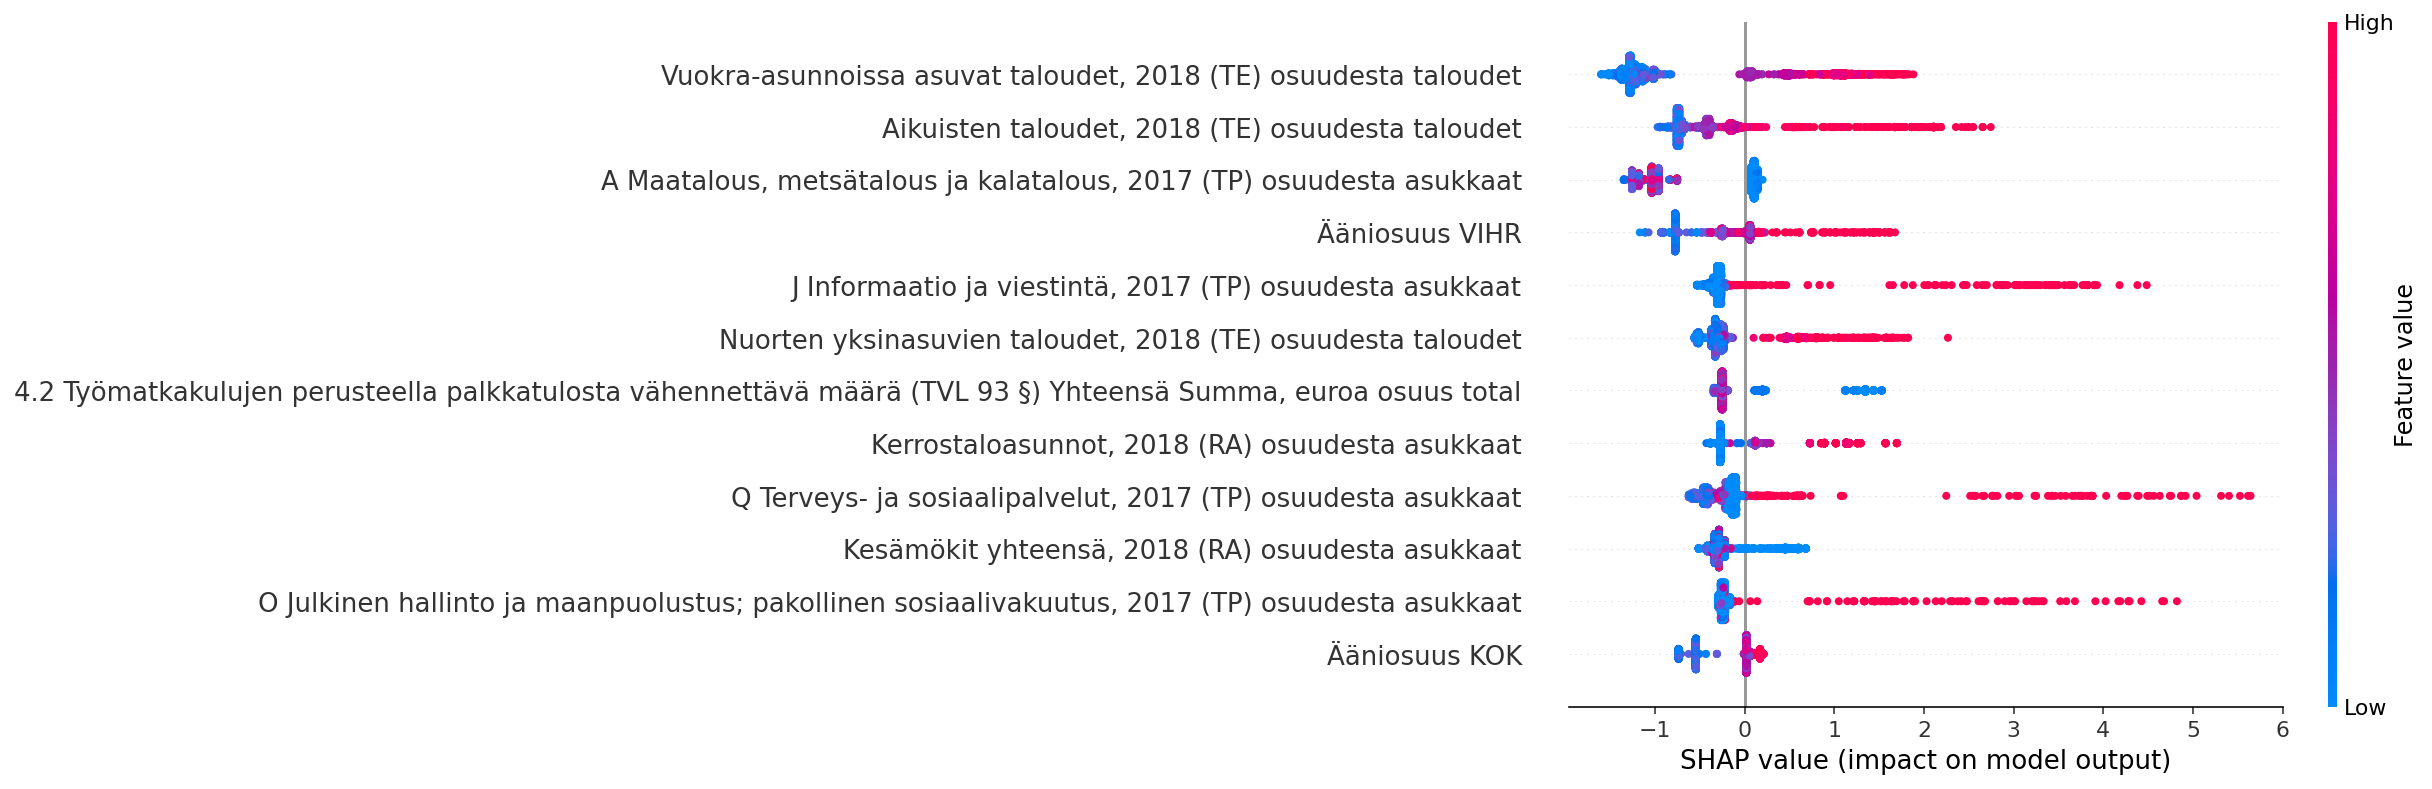

In [29]:
shap_index = 4
included_columns = []
columns = 12
scaled = False

compare_to = data[(data['cluster']) == shap_index].copy()
compare_to = create_share_of_values(compare_to)
compare_to = create_new_values(compare_to, vaalidata)

shap.summary_plot(shap_values[shap_index], X,  max_display=columns)

In [30]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=columns, scaled=scaled)

invalid value encountered in true_divide
invalid value encountered in true_divide


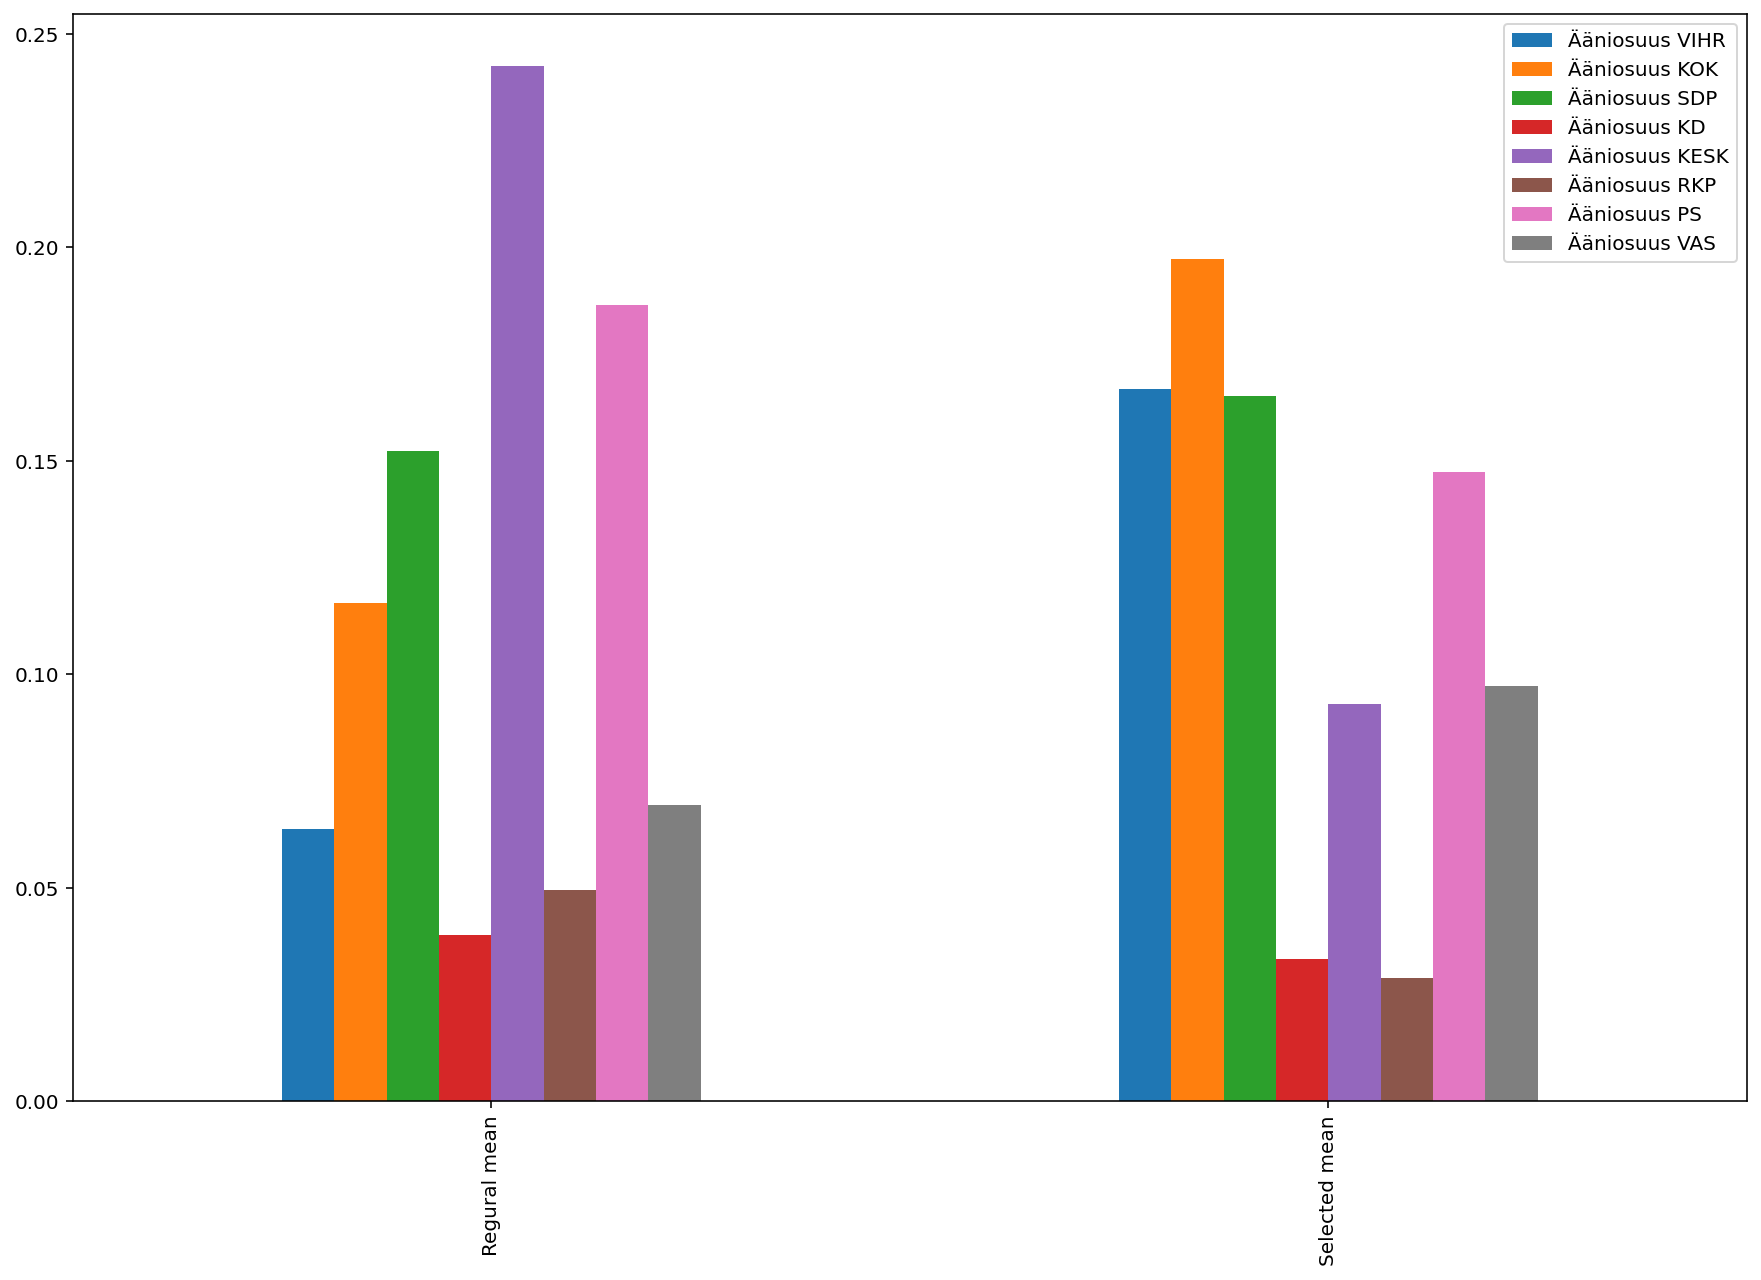

In [31]:
included_columns = all_included_columns
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=0, scaled=False)

In [32]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=columns)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
2317       80220       JOENSUU          Joensuu                        4074.0   
612        20730         TURKU            Turku                         532.0   
611        20720         TURKU            Turku                        6333.0   
62         00800      HELSINKI         Helsinki                        7319.0   
72         00910      HELSINKI         Helsinki                        5849.0   

     Suurin_puolue  Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat  \
2317          VIHR                                         0.526019   
612            SDP                                         0.657895   
611            SDP                                         0.450024   
62            VIHR                                         0.568384   
72            VIHR                                         0.602325   

      Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat  \
2317                                          0.001473   
612                                           0.000000   
611                                           0.000000   
62                                            0.000000   
72                                            0.000000   

      A Maatalous, metsätalous ja kalatalous, 2017 (TP) osuudesta asukkaat  \
2317                                                              0.000000   
612                                                               0.000000   
611                                                               0.000000   
62                                                                0.000410   
72                                                                0.000513   

      J Informaatio ja viestintä, 2017 (TP) osuudesta asukkaat  \
2317                                                  0.001718   
612                                                   0.000000   
611                                                   0.006632   
62                                                    0.003552   
72                                                    0.001197   

      O Julkinen hallinto ja maanpuolustus; pakollinen sosiaalivakuutus, 2017 (TP) osuudesta asukkaat  \
2317                                                                                         0.001718   
612                                                                                          0.000000   
611                                                                                          0.046423   
62                                                                                           0.000000   
72                                                                                           0.000000   

      Q Terveys- ja sosiaalipalvelut, 2017 (TP) osuudesta asukkaat  \
2317                                                      0.024300   
612                                                       0.000000   
611                                                       0.096479   
62                                                        0.075147   
72                                                        0.051975   

      Nuorten yksinasuvien taloudet, 2018 (TE) osuudesta taloudet  \
2317                                                     0.280946   
612                                                      0.161765   
611                                                      0.178228   
62                                                       0.148571   
72                                                       0.159474   

      Aikuisten taloudet, 2018 (TE) osuudesta taloudet  \
2317                                          0.667512   
612                                           0.570588   
611                                           0.499733   
62                                            0.576905   
72                                            0.575145   

      Vuokra-asunnoissa asuvat taloudet, 2018 (TE) osuudesta

In [34]:
pnro = '02160'
id_col = 'Postinumero'
target='cluster'
idx = data[data[id_col]==pnro].index.item()
shap_index = data[data[id_col]==pnro][target].item()

shap.decision_plot(shap_expected_value[shap_index], shap_values[shap_index][idx], X)


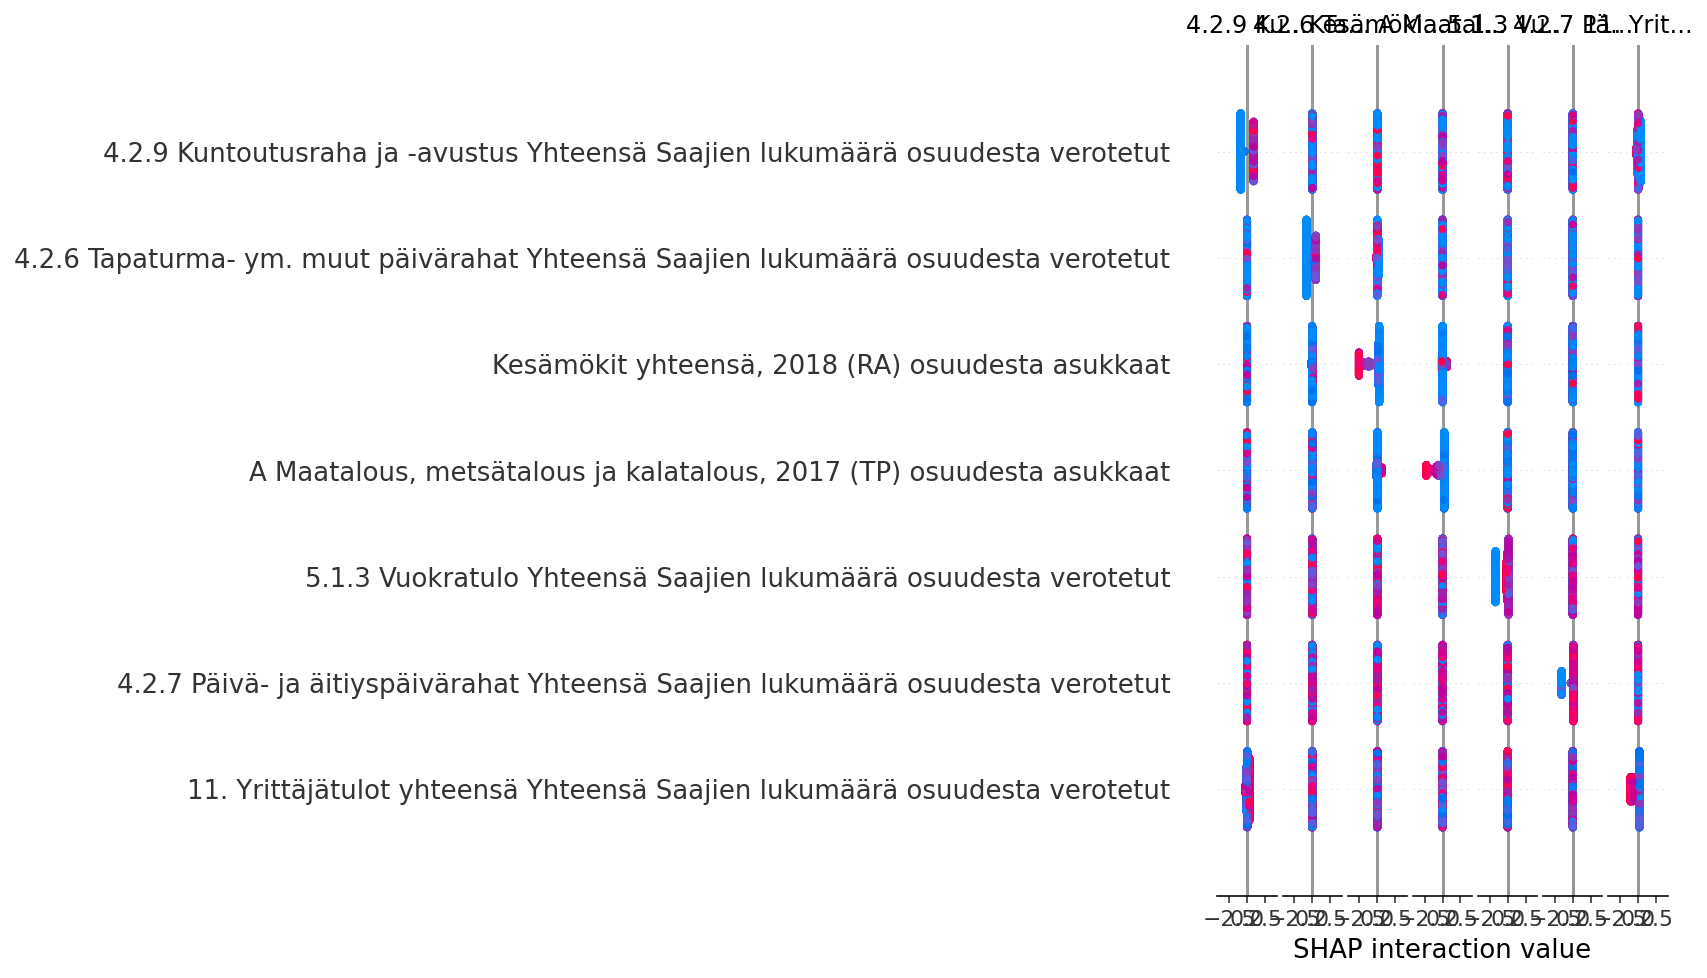

In [35]:
shap.summary_plot(shap_interaction_values[shap_index], X)